In [3]:
import coloredlogs, logging

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, date
import calendar
from dateutil.rrule import rrule, MONTHLY
from bisect import bisect

coloredlogs.install(level='DEBUG')
# coloredlogs.install(level='INFO')

from run import run, run_one, run_and_print

2019-04-01 16:43:50 engine-playground matplotlib.pyplot[4080] DEBUG Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Release schedule over the past three years.

### Monthly analysis

In [29]:
(repos, years, months, counts) = zip(*run('''
  SELECT repository_id,
         YEAR(commit_author_when) as year,
         MONTH(commit_author_when) as month,
         COUNT(*) as n
  FROM refs
  NATURAL JOIN commits
  WHERE ref_name LIKE 'refs/tags/v%.%.%'
    AND year >= 2015
  GROUP BY repository_id, year, month
  ORDER BY repository_id, year, month;
'''))

dates = set([datetime(year, month, 1) for (year, month) in zip(years, months)])
yearmonths = [(d.year, d.month) for d in rrule(MONTHLY, dtstart=min(dates), until=max(dates))]

counts_dict = {(r, y, m): c for (r, y, m, c) in zip(repos, years, months, counts)}
counts_per_repo = {r: [counts_dict.get((r, d[0], d[1]), 0) for d in yearmonths] for r in set(repos)}

2019-03-28 18:54:58 engine-playground root[8101] INFO done in 1.18 seconds


2019-03-28 18:54:59 engine-playground matplotlib.axes._base[8101] DEBUG update_title_pos
2019-03-28 18:55:00 engine-playground matplotlib.axes._base[8101] DEBUG update_title_pos
2019-03-28 18:55:00 engine-playground matplotlib.axes._base[8101] DEBUG update_title_pos
2019-03-28 18:55:00 engine-playground matplotlib.axes._base[8101] DEBUG update_title_pos


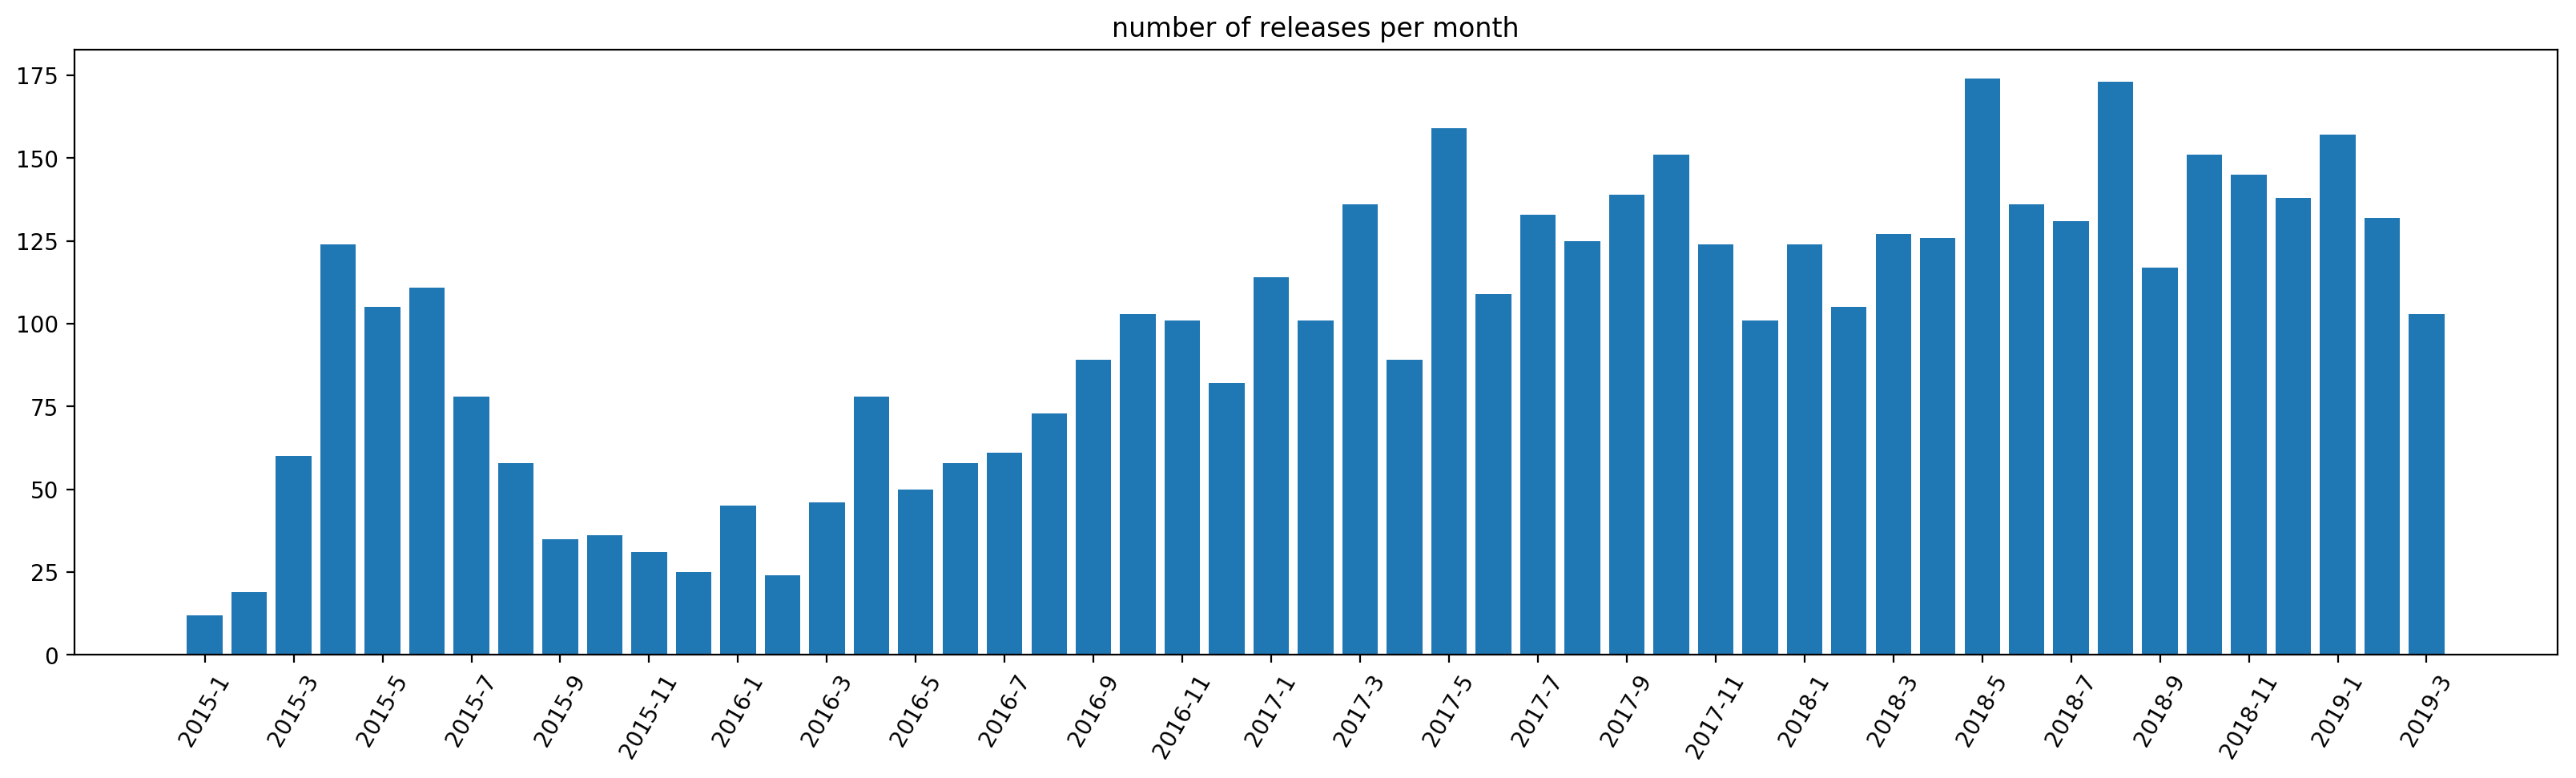

In [30]:
labels = ['%d-%d' % (y, m) for (y, m) in yearmonths]
total_counts = np.sum(list(counts_per_repo.values()), axis=0)

plt.figure(figsize=(20,5), dpi=200)
plt.title('number of releases per month')
plt.bar(labels, total_counts)
plt.xticks(labels[::2], rotation=60)
plt.show()

2019-03-28 18:55:03 engine-playground matplotlib.axes._base[8101] DEBUG update_title_pos
2019-03-28 18:55:04 engine-playground matplotlib.axes._base[8101] DEBUG update_title_pos
2019-03-28 18:55:05 engine-playground matplotlib.axes._base[8101] DEBUG update_title_pos
2019-03-28 18:55:05 engine-playground matplotlib.axes._base[8101] DEBUG update_title_pos


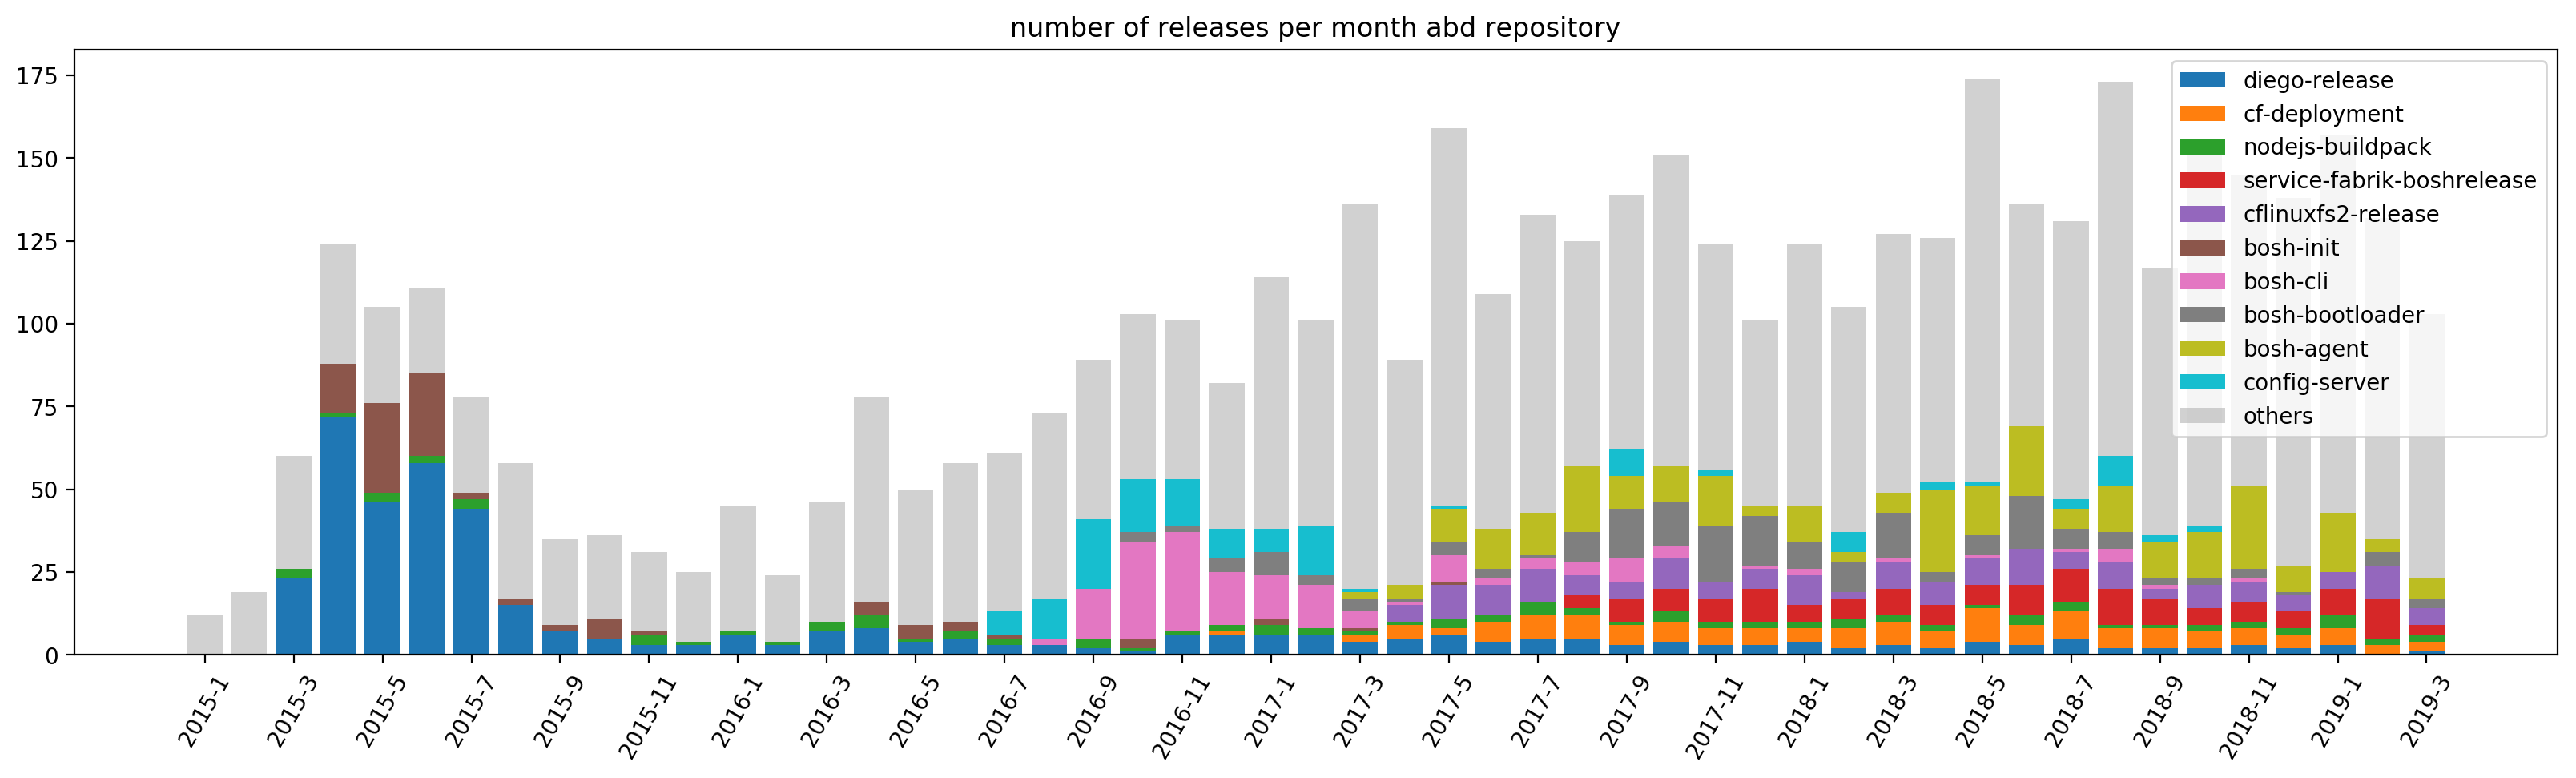

In [31]:
top_n = 10
treshold = sorted(np.array(list(counts_per_repo.values())).sum(axis=1))[-top_n]
top_repos = list({repo for repo in counts_per_repo if sum(counts_per_repo[repo]) >= treshold})
others = np.sum([counts_per_repo[repo] for repo in counts_per_repo if repo not in top_repos], axis=0)

total = np.zeros(len(yearmonths))
plt.figure(figsize=(20,5), dpi=200)
plt.title('number of releases per month abd repository')
for repo in top_repos:
    plt.bar(labels, counts_per_repo[repo], bottom=total)
    total = total + counts_per_repo[repo]
plt.bar(labels, others, bottom=total, color=(0.7, 0.7, 0.7, 0.6))
plt.xticks(labels[::2], rotation=60)
top_repos.append('others')
plt.legend(top_repos)
plt.show()

In [32]:
# save to csv
np.savetxt('data/top_repos.csv', np.array(top_repos), fmt='%s')
for repo in top_repos[:-1]:
    np.savetxt('data/'+repo+'.csv', counts_per_repo[repo])
np.savetxt('data/others.csv', others)
np.savetxt('data/dates.csv', np.array(labels), fmt='%s')

### Daily analysis

In [283]:
(repos, years, months, days, counts) = zip(*run('''
  SELECT repository_id,
         YEAR(commit_author_when) as year,
         MONTH(commit_author_when) as month,
         DAY(commit_author_when) as day,
         COUNT(*) as n
  FROM refs
  NATURAL JOIN commits
  WHERE ref_name LIKE 'refs/tags/v%.%.%'
    AND year >= 2016
  GROUP BY repository_id, year, month, day
  ORDER BY repository_id, year, month, day;
'''))

dates = set([date(year, month, day) for (year, month, day) in zip(years, months, days)])
dates = rrule(DAILY, dtstart=min(dates), until=max(dates))

counts_dict = {(r, date(y, m, d)): c for (r, y, m, d, c) in zip(repos, years, months, days, counts)}
counts_per_repo = {r: [counts_dict.get((r, d.date()), 0) for d in dates] for r in set(repos)}

2019-03-27 19:41:03 engine-playground root[28221] INFO done in 0.87 seconds


2019-03-27 19:41:06 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 19:41:07 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 19:41:08 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 19:41:09 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos


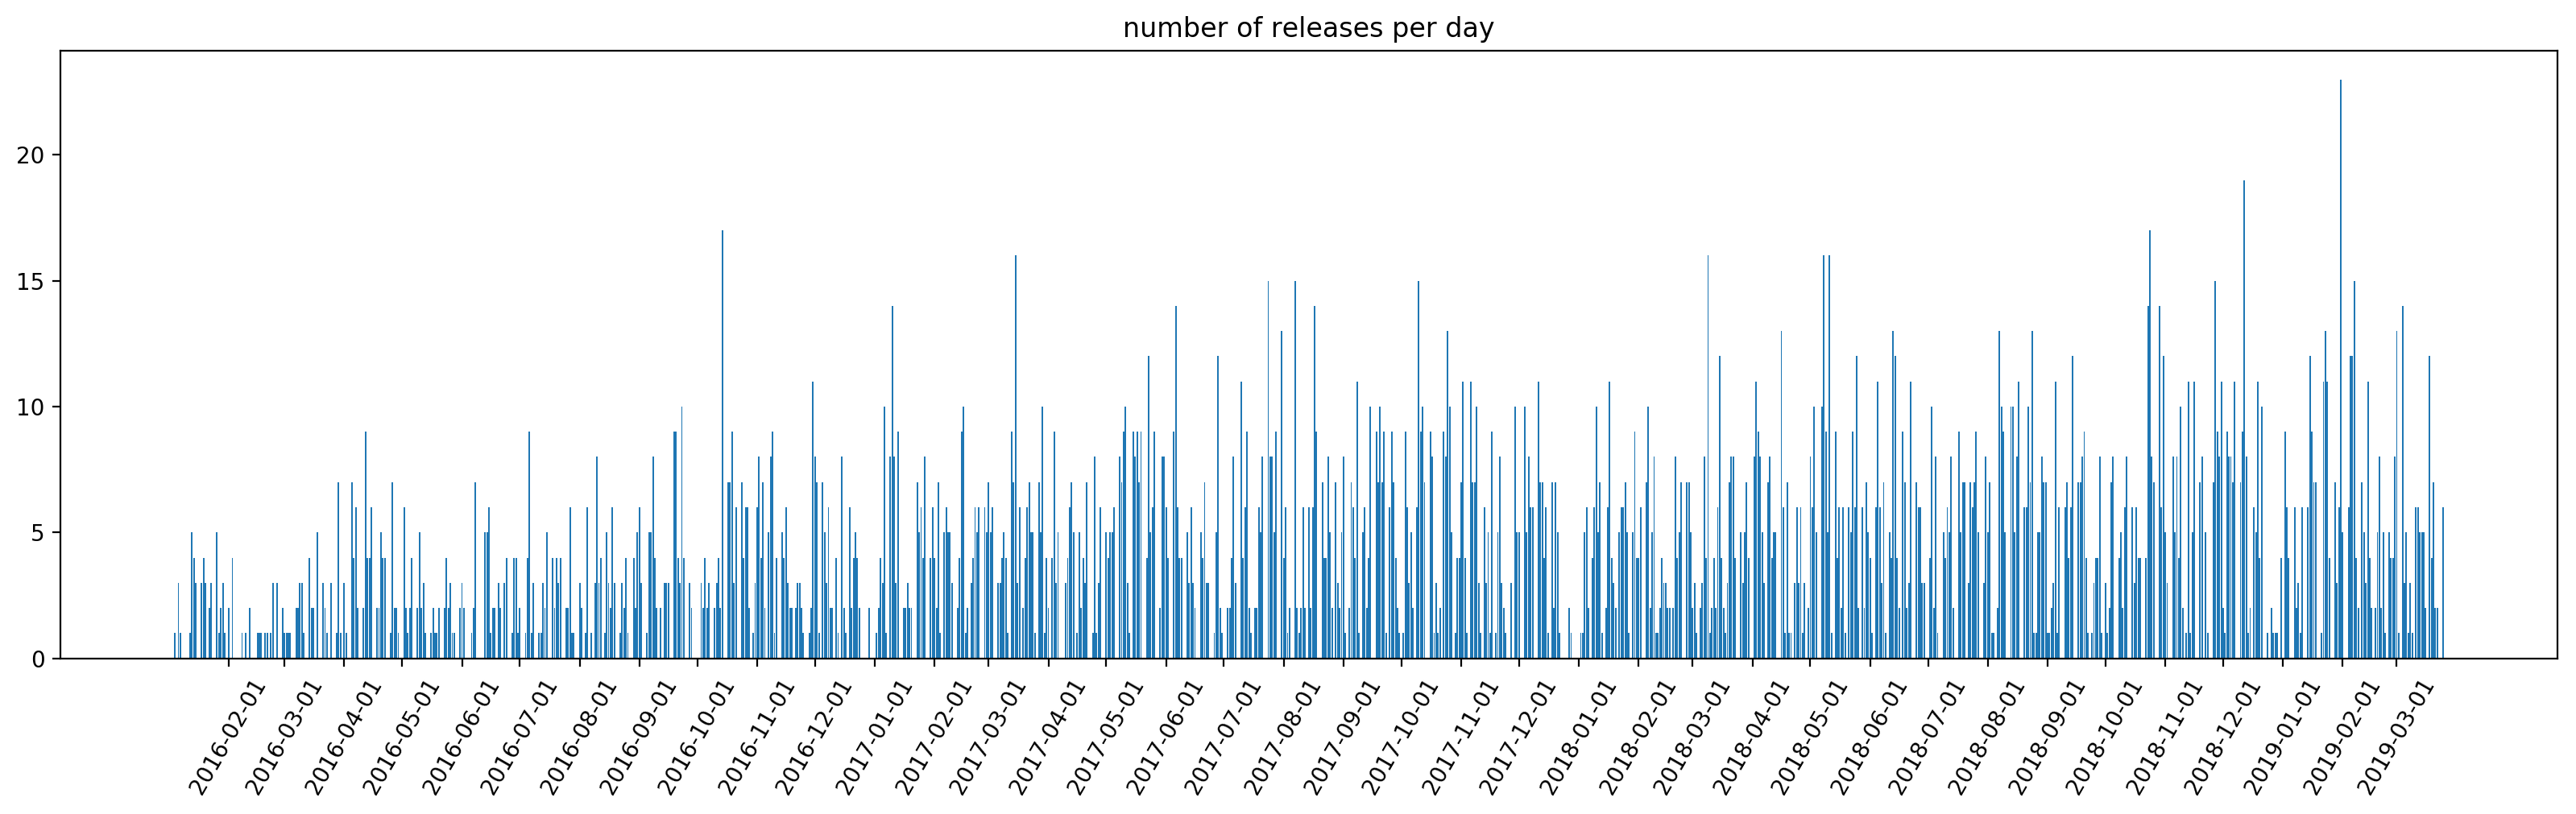

In [284]:
labels = [d.date().isoformat() for d in dates]
total_counts = np.sum(list(counts_per_repo.values()), axis=0)

plt.figure(figsize=(20,5), dpi=200)
plt.title('number of releases per day')
plt.bar(labels, total_counts)
plt.xticks([d.date().isoformat() for d in dates if d.day == 1], rotation=60)
plt.show()

2019-03-27 19:41:48 engine-playground root[28221] INFO done in 0.71 seconds
2019-03-27 19:41:49 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 19:41:50 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 19:41:50 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 19:41:51 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos


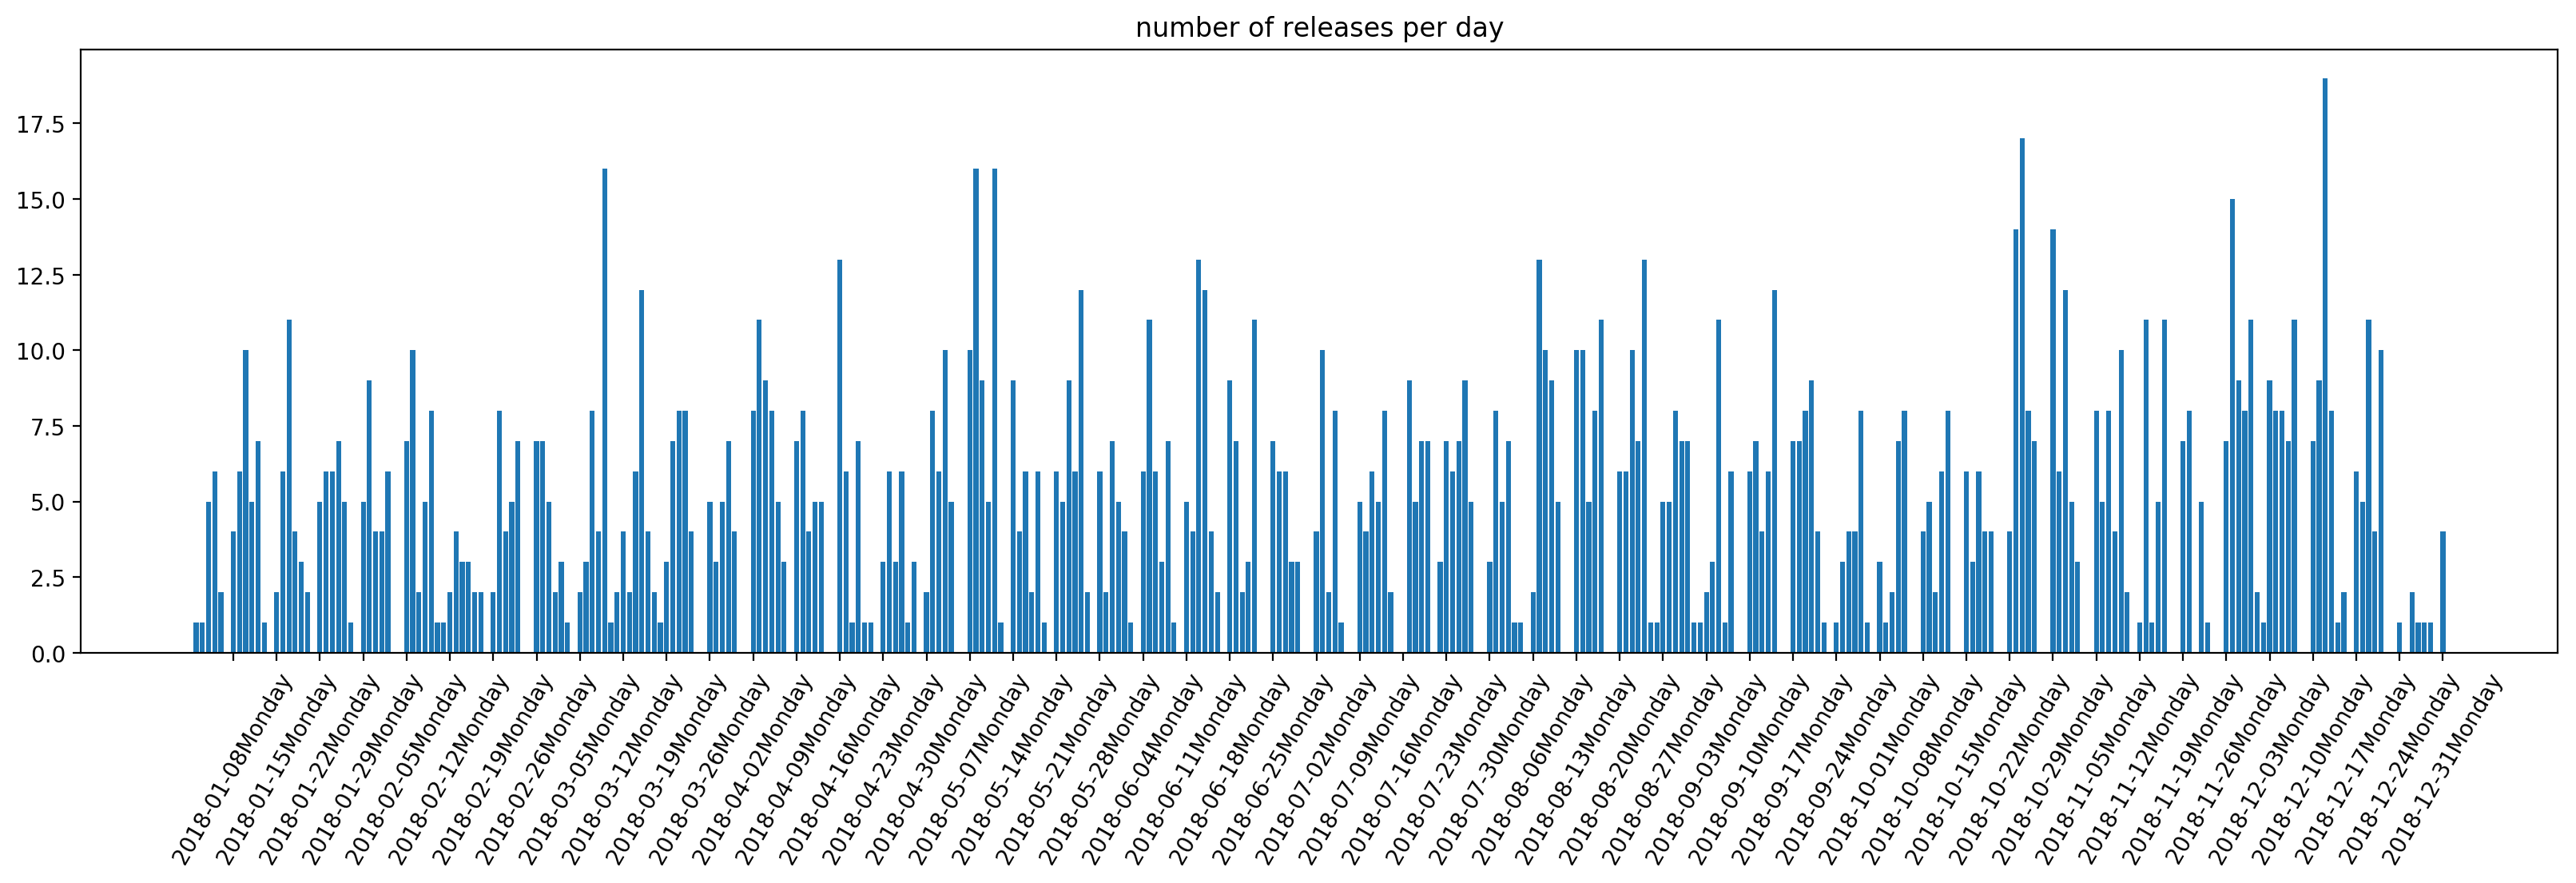

In [285]:
(repos, years, months, days, counts) = zip(*run('''
  SELECT repository_id,
         YEAR(commit_author_when) as year,
         MONTH(commit_author_when) as month,
         DAY(commit_author_when) as day,
         COUNT(*) as n
  FROM refs
  NATURAL JOIN commits
  WHERE ref_name LIKE 'refs/tags/v%.%.%'
    AND year = 2018
  GROUP BY repository_id, year, month, day
  ORDER BY repository_id, year, month, day;
'''))

dates = set([date(year, month, day) for (year, month, day) in zip(years, months, days)])
dates = rrule(DAILY, dtstart=min(dates), until=max(dates))

counts_dict = {(r, date(y, m, d)): c for (r, y, m, d, c) in zip(repos, years, months, days, counts)}
counts_per_repo = {r: [counts_dict.get((r, d.date()), 0) for d in dates] for r in set(repos)}

labels = [d.date().isoformat() + calendar.day_name[d.weekday()] for d in dates]
total_counts = np.sum(list(counts_per_repo.values()), axis=0)

plt.figure(figsize=(20,5), dpi=200)
plt.title('number of releases per day')
plt.bar(labels, total_counts)
plt.xticks([l for l in labels if 'Monday' in l], rotation=60)
plt.show()

In [ ]:
(weekdays, counts) = zip(*run('''
  SELECT WEEKDAY(commit_author_when) as weekday,
         COUNT(*) as n
  FROM refs
  NATURAL JOIN commits
  WHERE ref_name LIKE 'refs/tags/v%.%.%'
  GROUP BY weekday
  ORDER BY weekday;
'''))

plt.figure(figsize=(20,5), dpi=200)
plt.title('number of releases per weekday')
plt.bar(list(calendar.day_name), counts)
plt.xticks(rotation=60)
plt.show()

## Number of commits per month

2019-03-27 20:17:33 engine-playground root[28221] INFO done in 11.94 seconds
2019-03-27 20:17:33 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 20:17:34 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 20:17:34 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 20:17:34 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos


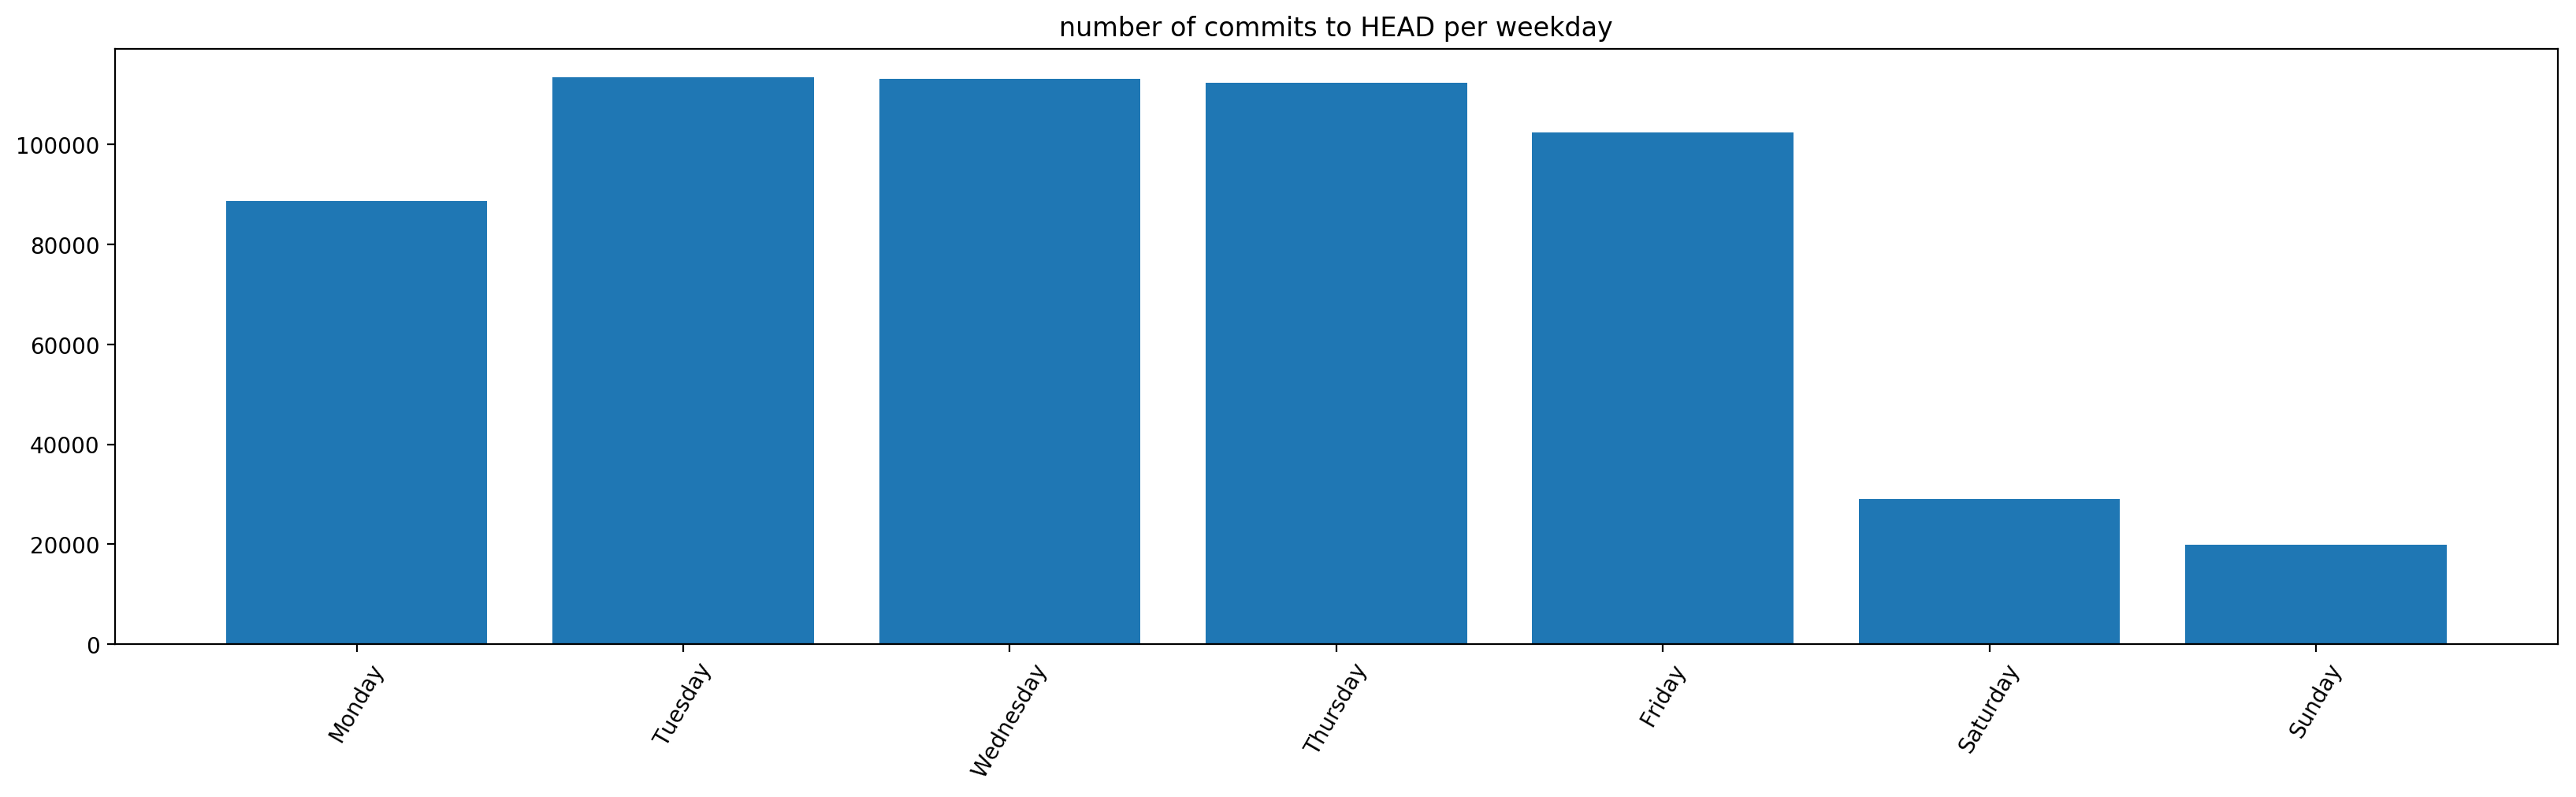

In [366]:
(weekdays, counts) = zip(*run('''
  SELECT WEEKDAY(commit_author_when) as weekday, COUNT(*) as n
  FROM ref_commits
  NATURAL JOIN commits
  WHERE ref_name = 'HEAD'
  GROUP BY weekday
  ORDER BY weekday;
'''))

plt.figure(figsize=(20,5), dpi=200)
plt.title('number of commits to HEAD per weekday')
plt.bar(list(calendar.day_name), counts)
plt.xticks(rotation=60)
plt.show()

2019-03-27 20:24:03 engine-playground root[28221] INFO done in 7.95 seconds
2019-03-27 20:24:04 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 20:24:04 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 20:24:05 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 20:24:05 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos


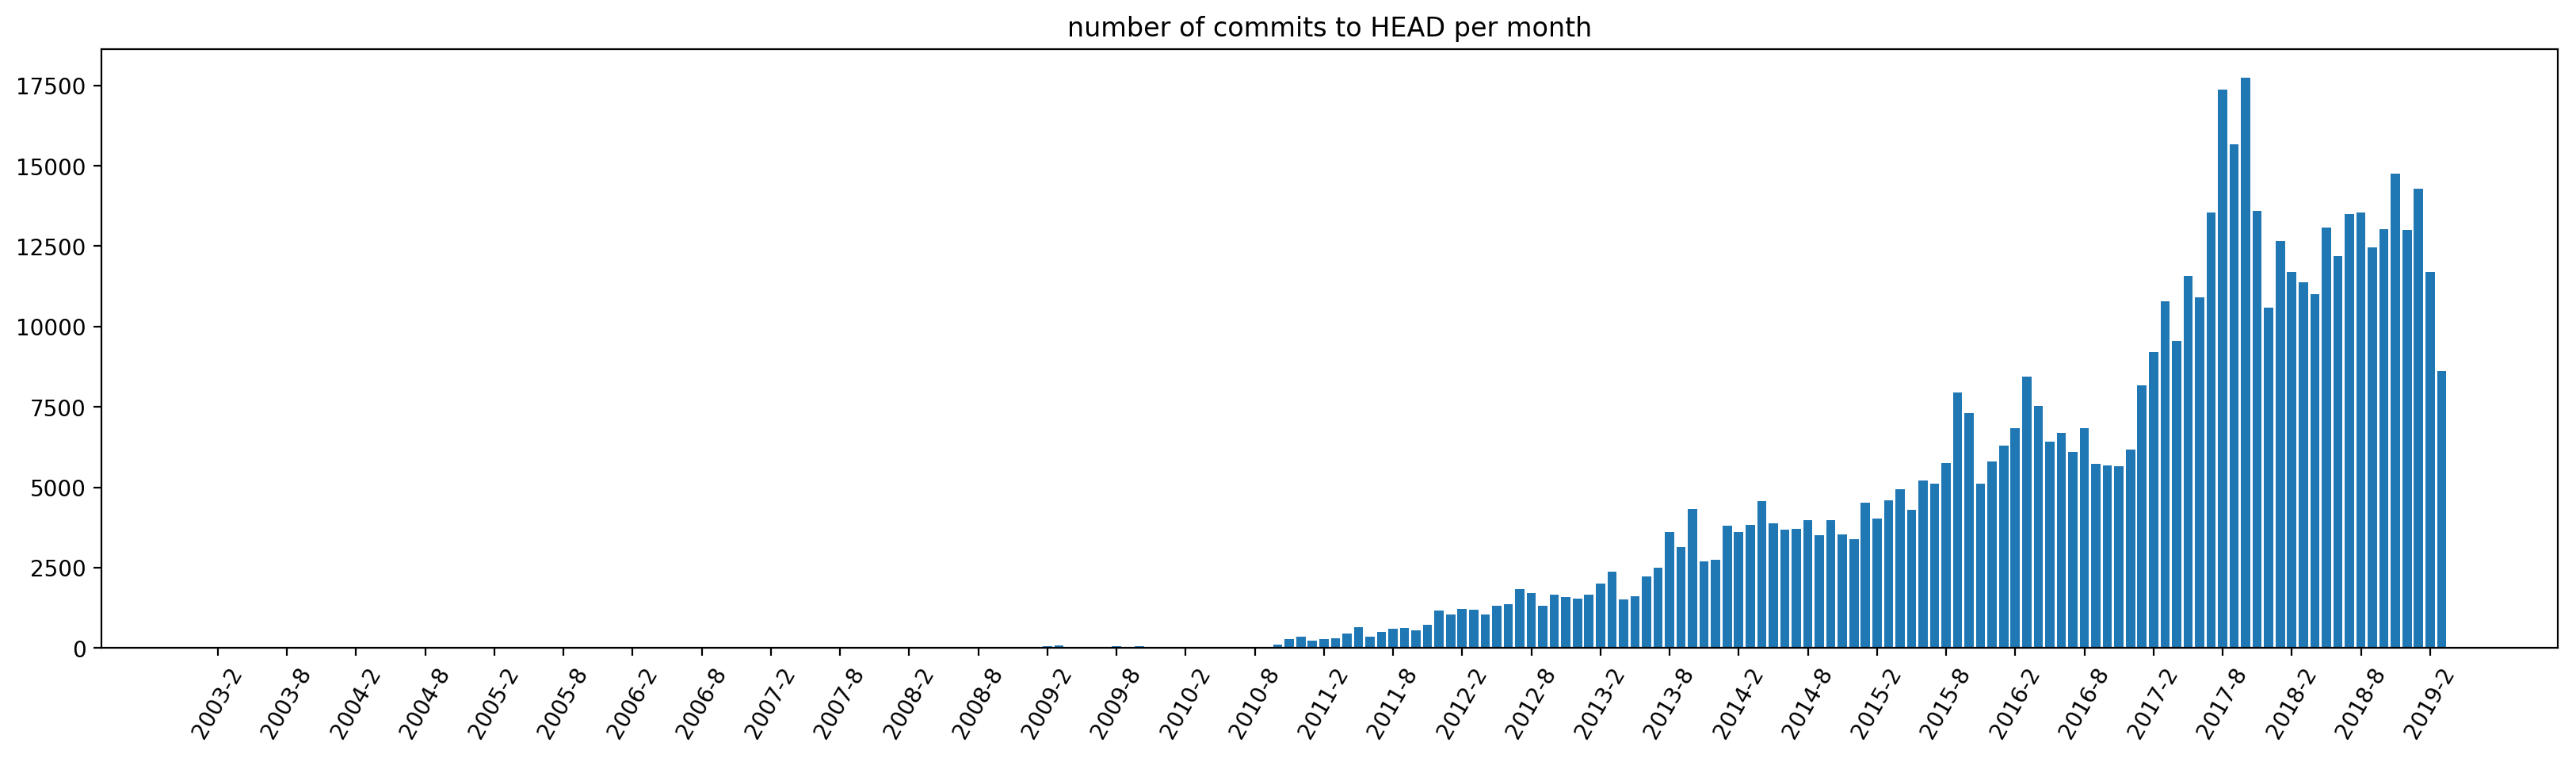

In [371]:
(years, months, counts) = zip(*run('''
  SELECT YEAR(commit_author_when) as year,
         MONTH(commit_author_when) as month,
         COUNT(*) as n
  FROM ref_commits
  NATURAL JOIN commits
  WHERE ref_name = 'HEAD'
  GROUP BY year, month
  ORDER BY year, month;
'''))

dates = set([datetime(year, month, 1) for (year, month) in zip(years, months)])
yearmonths = [(d.year, d.month) for d in rrule(MONTHLY, dtstart=min(dates), until=max(dates))]

counts_per_month = {(y, m): c for (y, m, c) in zip(years, months, counts)}
labels = ['%d-%d' % (y, m) for (y, m) in yearmonths]
counts = [counts_per_month.get((y, m), 0) for (y, m) in yearmonths]

plt.figure(figsize=(20,5), dpi=200)
plt.title('number of commits to HEAD per month')
plt.bar(labels, counts)
plt.xticks(labels[::6], rotation=60)
plt.show()

2019-03-27 20:25:09 engine-playground root[28221] INFO done in 7.89 seconds
2019-03-27 20:25:09 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 20:25:10 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 20:25:10 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos
2019-03-27 20:25:10 engine-playground matplotlib.axes._base[28221] DEBUG update_title_pos


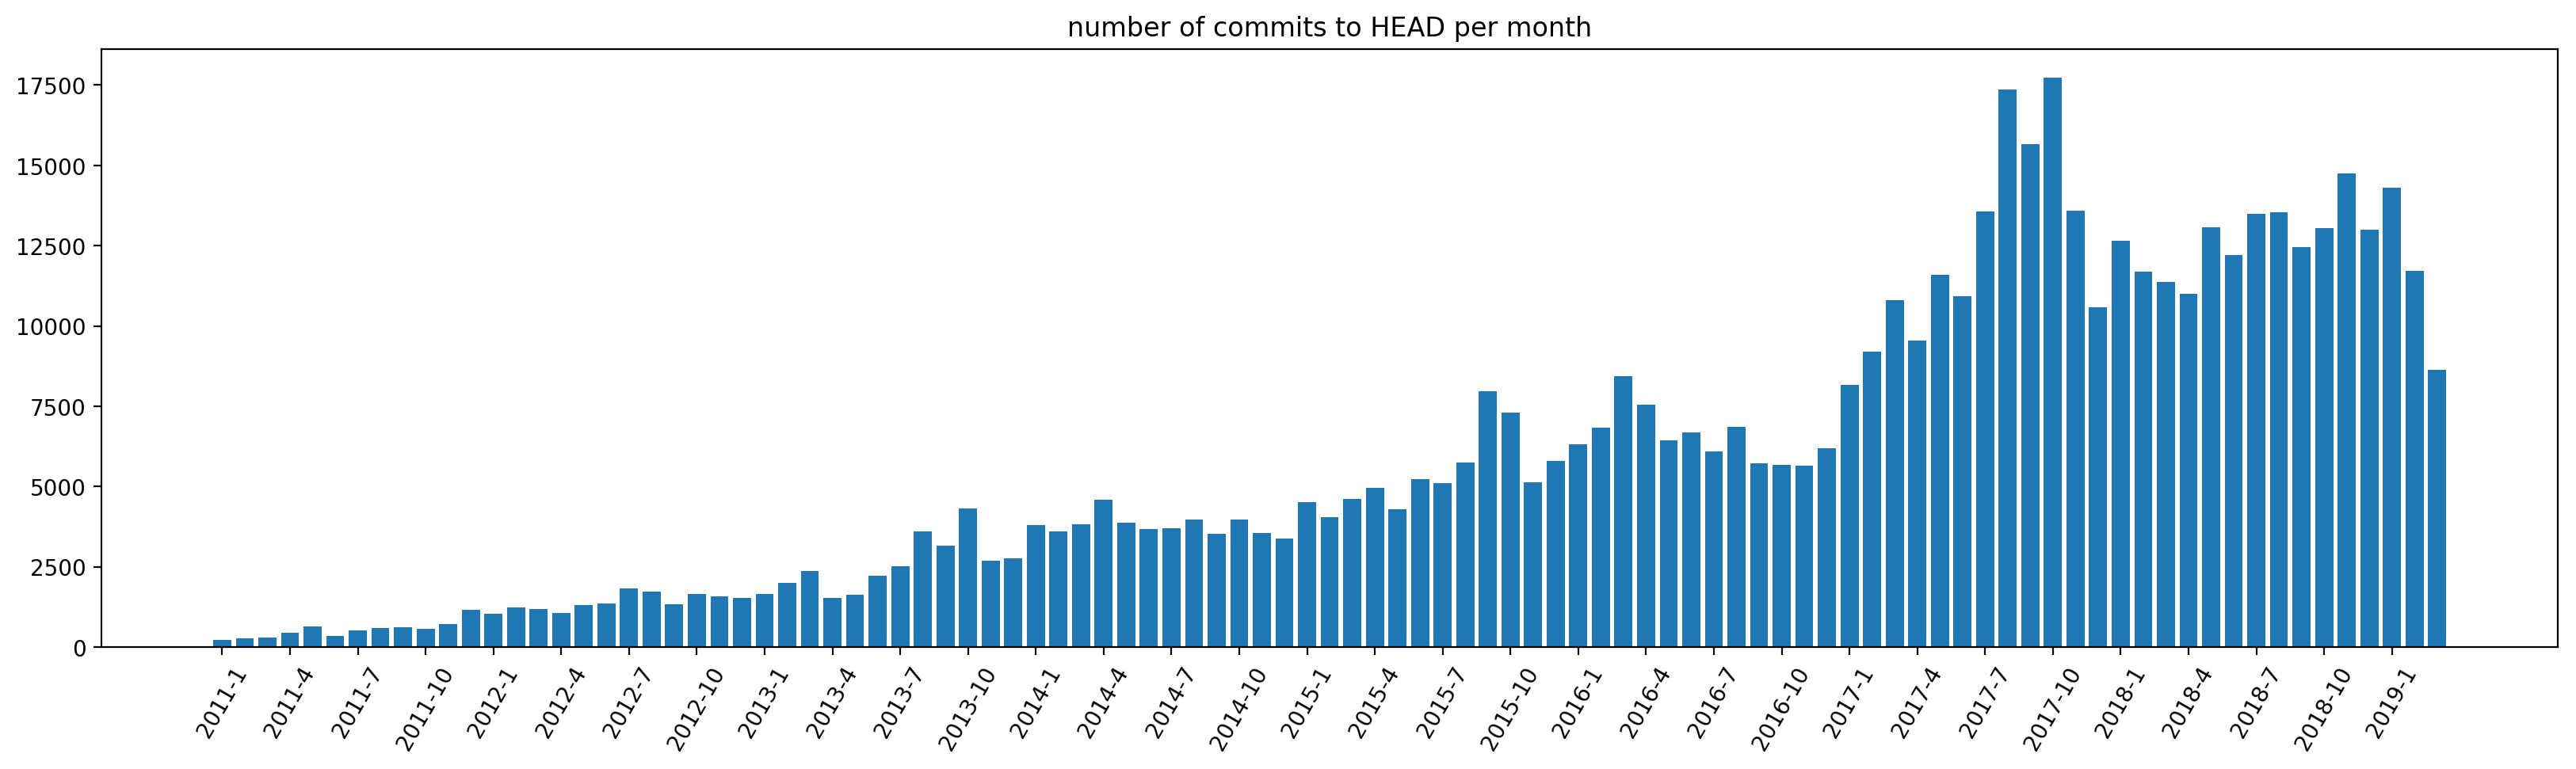

In [373]:
# let's count only starting in 2011

(years, months, counts) = zip(*run('''
  SELECT YEAR(commit_author_when) as year,
         MONTH(commit_author_when) as month,
         COUNT(*) as n
  FROM ref_commits
  NATURAL JOIN commits
  WHERE ref_name = 'HEAD'
    AND year > 2010
  GROUP BY year, month
  ORDER BY year, month;
'''))

dates = set([datetime(year, month, 1) for (year, month) in zip(years, months)])
yearmonths = [(d.year, d.month) for d in rrule(MONTHLY, dtstart=min(dates), until=max(dates))]

counts_per_month = {(y, m): c for (y, m, c) in zip(years, months, counts)}
labels = ['%d-%d' % (y, m) for (y, m) in yearmonths]
counts = [counts_per_month.get((y, m), 0) for (y, m) in yearmonths]

plt.figure(figsize=(20,5), dpi=200)
plt.title('number of commits to HEAD per month')
plt.bar(labels, counts)
plt.xticks(labels[::3], rotation=60)
plt.show()

In [3]:
# let's show repos too

(repos, years, months, counts) = zip(*run('''
  SELECT repository_id,
         YEAR(commit_author_when) as year,
         MONTH(commit_author_when) as month,
         COUNT(*) as n
  FROM ref_commits
  NATURAL JOIN commits
  WHERE ref_name = 'HEAD'
    AND year > 2010
  GROUP BY repository_id, year, month
  ORDER BY repository_id, year, month;
'''))

dates = set([datetime(year, month, 1) for (year, month) in zip(years, months)])
yearmonths = [(d.year, d.month) for d in rrule(MONTHLY, dtstart=min(dates), until=max(dates))]
counts_dict = {(r, y, m): c for (r, y, m, c) in zip(repos, years, months, counts)}
counts_per_repo = {r: [counts_dict.get((r, d[0], d[1]), 0) for d in yearmonths] for r in set(repos)}

2019-03-28 18:32:10 engine-playground root[8101] INFO done in 12.85 seconds


2019-03-28 18:32:13 engine-playground matplotlib.axes._base[8101] DEBUG update_title_pos
2019-03-28 18:32:13 engine-playground matplotlib.font_manager[8101] DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/francesc/.local/lib/python3.5/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2019-03-28 18:32:13 engine-playground matplotlib.font_manager[8101] DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/francesc/.local/lib/python3.5/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2019-03-28 18:32:14 engine-playground matplotlib.axes._base[8101] DEBUG update_title_pos
2019-03-28 18:32:15 engine-playground matplotlib.axes._base[8101] DEBUG update_title_pos
2019-03-28 18:32:16 engine-playground matplotlib.axes._base[8101] DEBUG update_title_pos


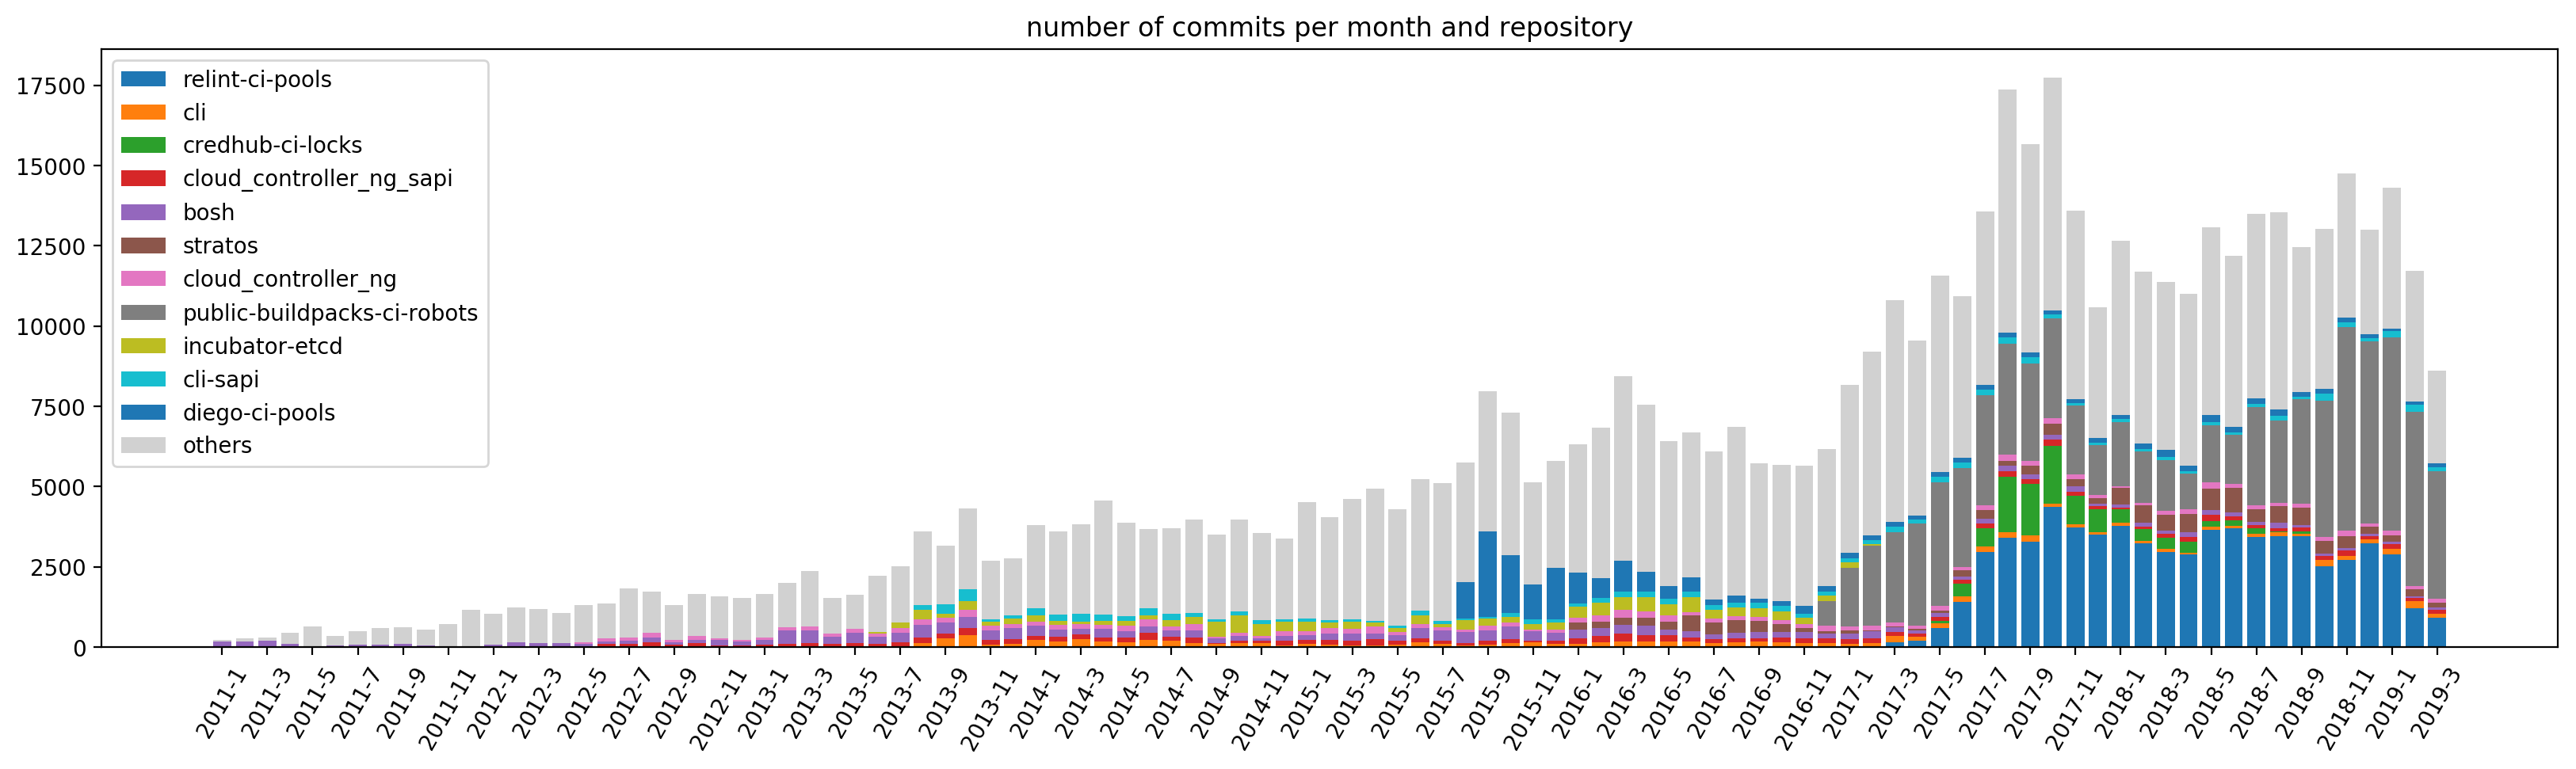

In [4]:
top_n = 10
treshold = sorted(np.array(list(counts_per_repo.values())).sum(axis=1))[-top_n]
top_repos = list({repo for repo in counts_per_repo if sum(counts_per_repo[repo]) >= treshold})
others = np.sum([counts_per_repo[repo] for repo in counts_per_repo if repo not in top_repos], axis=0)
labels = ['%d-%d' % (y, m) for (y, m) in yearmonths]

total = np.zeros(len(yearmonths))
plt.figure(figsize=(20,5), dpi=200)
plt.title('number of commits per month and repository')
for repo in top_repos:
    plt.bar(labels, counts_per_repo[repo], bottom=total)
    total = total + counts_per_repo[repo]
plt.bar(labels, others, bottom=total, color=(0.7, 0.7, 0.7, 0.6))
plt.xticks(labels[::2], rotation=60)
top_repos.append('others')
plt.legend(top_repos)
plt.show()

In [28]:
# save to csv
np.savetxt('data/top_repos.csv', np.array(top_repos), fmt='%s')
for repo in top_repos[:-1]:
    np.savetxt('data/'+repo+'.csv', counts_per_repo[repo])
np.savetxt('data/others.csv', others)
np.savetxt('data/dates.csv', np.array(labels), fmt='%s')

2019-03-27 20:52:09 engine-playground root[16590] INFO done in 7.40 seconds
2019-03-27 20:52:10 engine-playground matplotlib.axes._base[16590] DEBUG update_title_pos
2019-03-27 20:52:11 engine-playground matplotlib.axes._base[16590] DEBUG update_title_pos
2019-03-27 20:52:11 engine-playground matplotlib.axes._base[16590] DEBUG update_title_pos
2019-03-27 20:52:12 engine-playground matplotlib.axes._base[16590] DEBUG update_title_pos


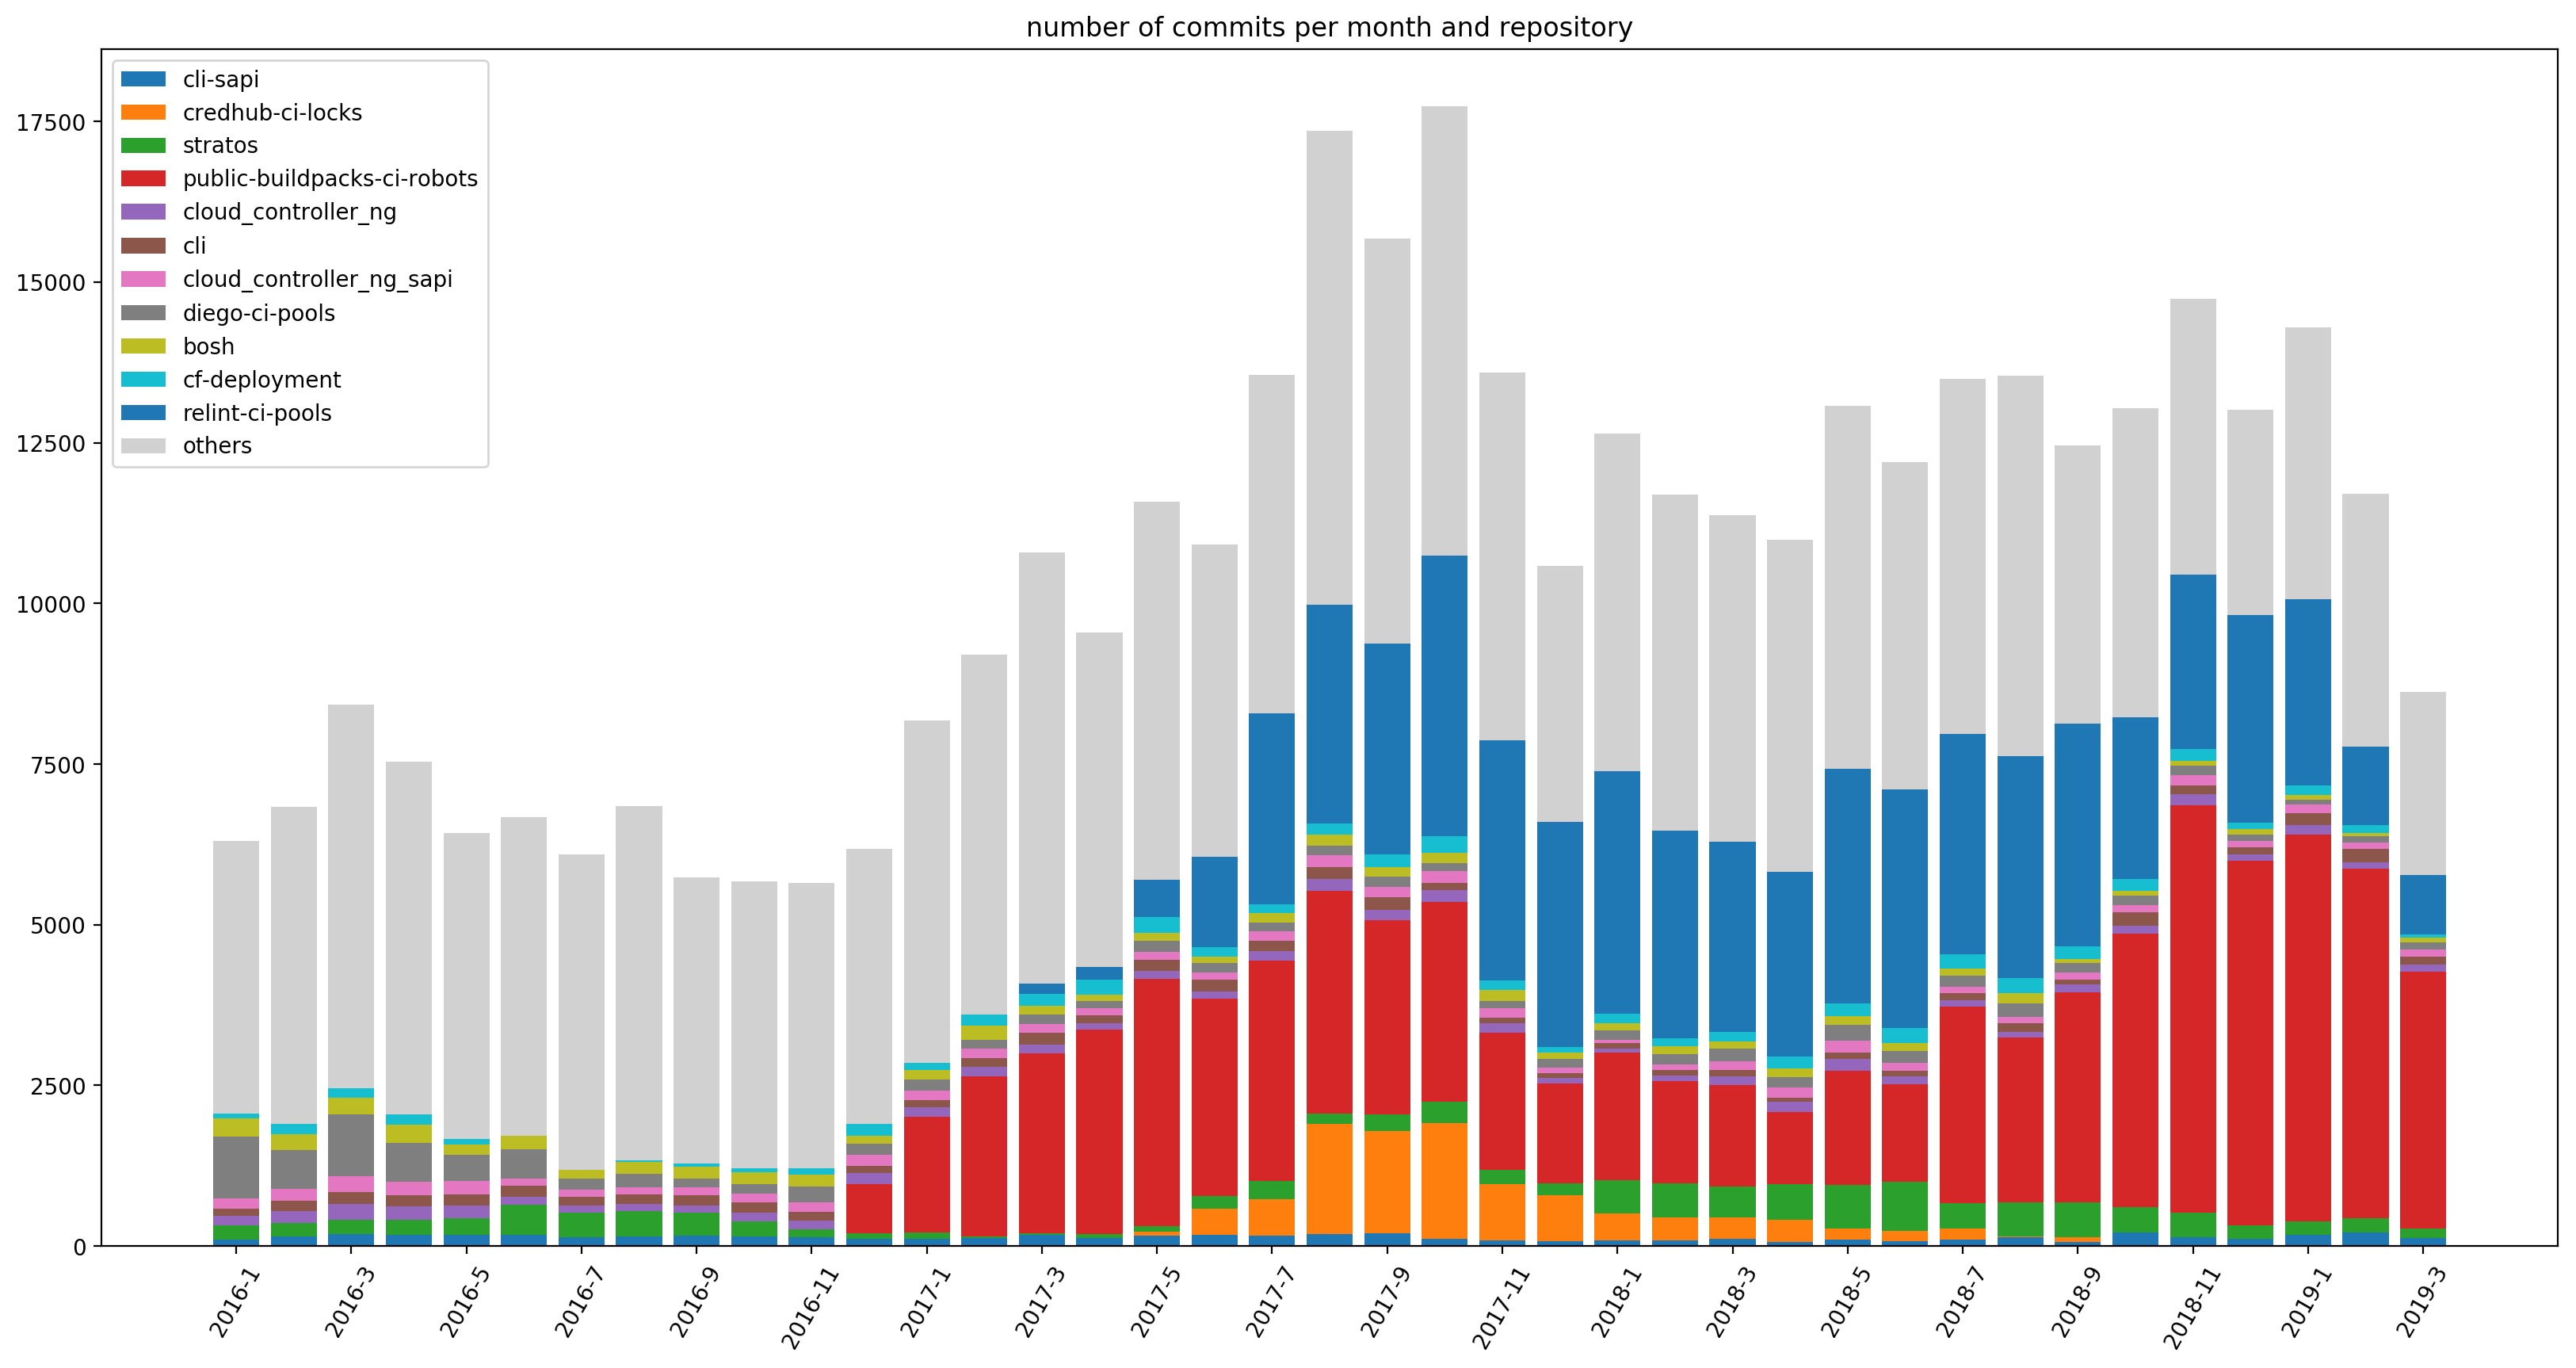

In [10]:
# let's focus on what's happened since 2016

(repos, years, months, counts) = zip(*run('''
  SELECT repository_id,
         YEAR(commit_author_when) as year,
         MONTH(commit_author_when) as month,
         COUNT(*) as n
  FROM ref_commits
  NATURAL JOIN commits
  WHERE ref_name = 'HEAD'
    AND year >= 2016
  GROUP BY repository_id, year, month
  ORDER BY repository_id, year, month;
'''))

dates = set([datetime(year, month, 1) for (year, month) in zip(years, months)])
yearmonths = [(d.year, d.month) for d in rrule(MONTHLY, dtstart=min(dates), until=max(dates))]
counts_dict = {(r, y, m): c for (r, y, m, c) in zip(repos, years, months, counts)}
counts_per_repo = {r: [counts_dict.get((r, d[0], d[1]), 0) for d in yearmonths] for r in set(repos)}

top_n = 10
treshold = sorted(np.array(list(counts_per_repo.values())).sum(axis=1))[-top_n]
top_repos = list({repo for repo in counts_per_repo if sum(counts_per_repo[repo]) >= treshold})
others = np.sum([counts_per_repo[repo] for repo in counts_per_repo if repo not in top_repos], axis=0)
labels = ['%d-%d' % (y, m) for (y, m) in yearmonths]

total = np.zeros(len(yearmonths))
plt.figure(figsize=(20,10), dpi=200)
plt.title('number of commits per month and repository')
for repo in top_repos:
    plt.bar(labels, counts_per_repo[repo], bottom=total)
    total = total + counts_per_repo[repo]
plt.bar(labels, others, bottom=total, color=(0.7, 0.7, 0.7, 0.6))
plt.xticks(labels[::2], rotation=60)
top_repos.append('others')
plt.legend(top_repos)
plt.show()

## Top repositories by number of commits

2019-03-28 00:09:05 engine-playground root[16590] INFO done in 5.96 seconds
2019-03-28 00:09:05 engine-playground matplotlib.axes._base[16590] DEBUG update_title_pos
2019-03-28 00:09:05 engine-playground matplotlib.axes._base[16590] DEBUG update_title_pos
2019-03-28 00:09:06 engine-playground matplotlib.axes._base[16590] DEBUG update_title_pos
2019-03-28 00:09:06 engine-playground matplotlib.axes._base[16590] DEBUG update_title_pos


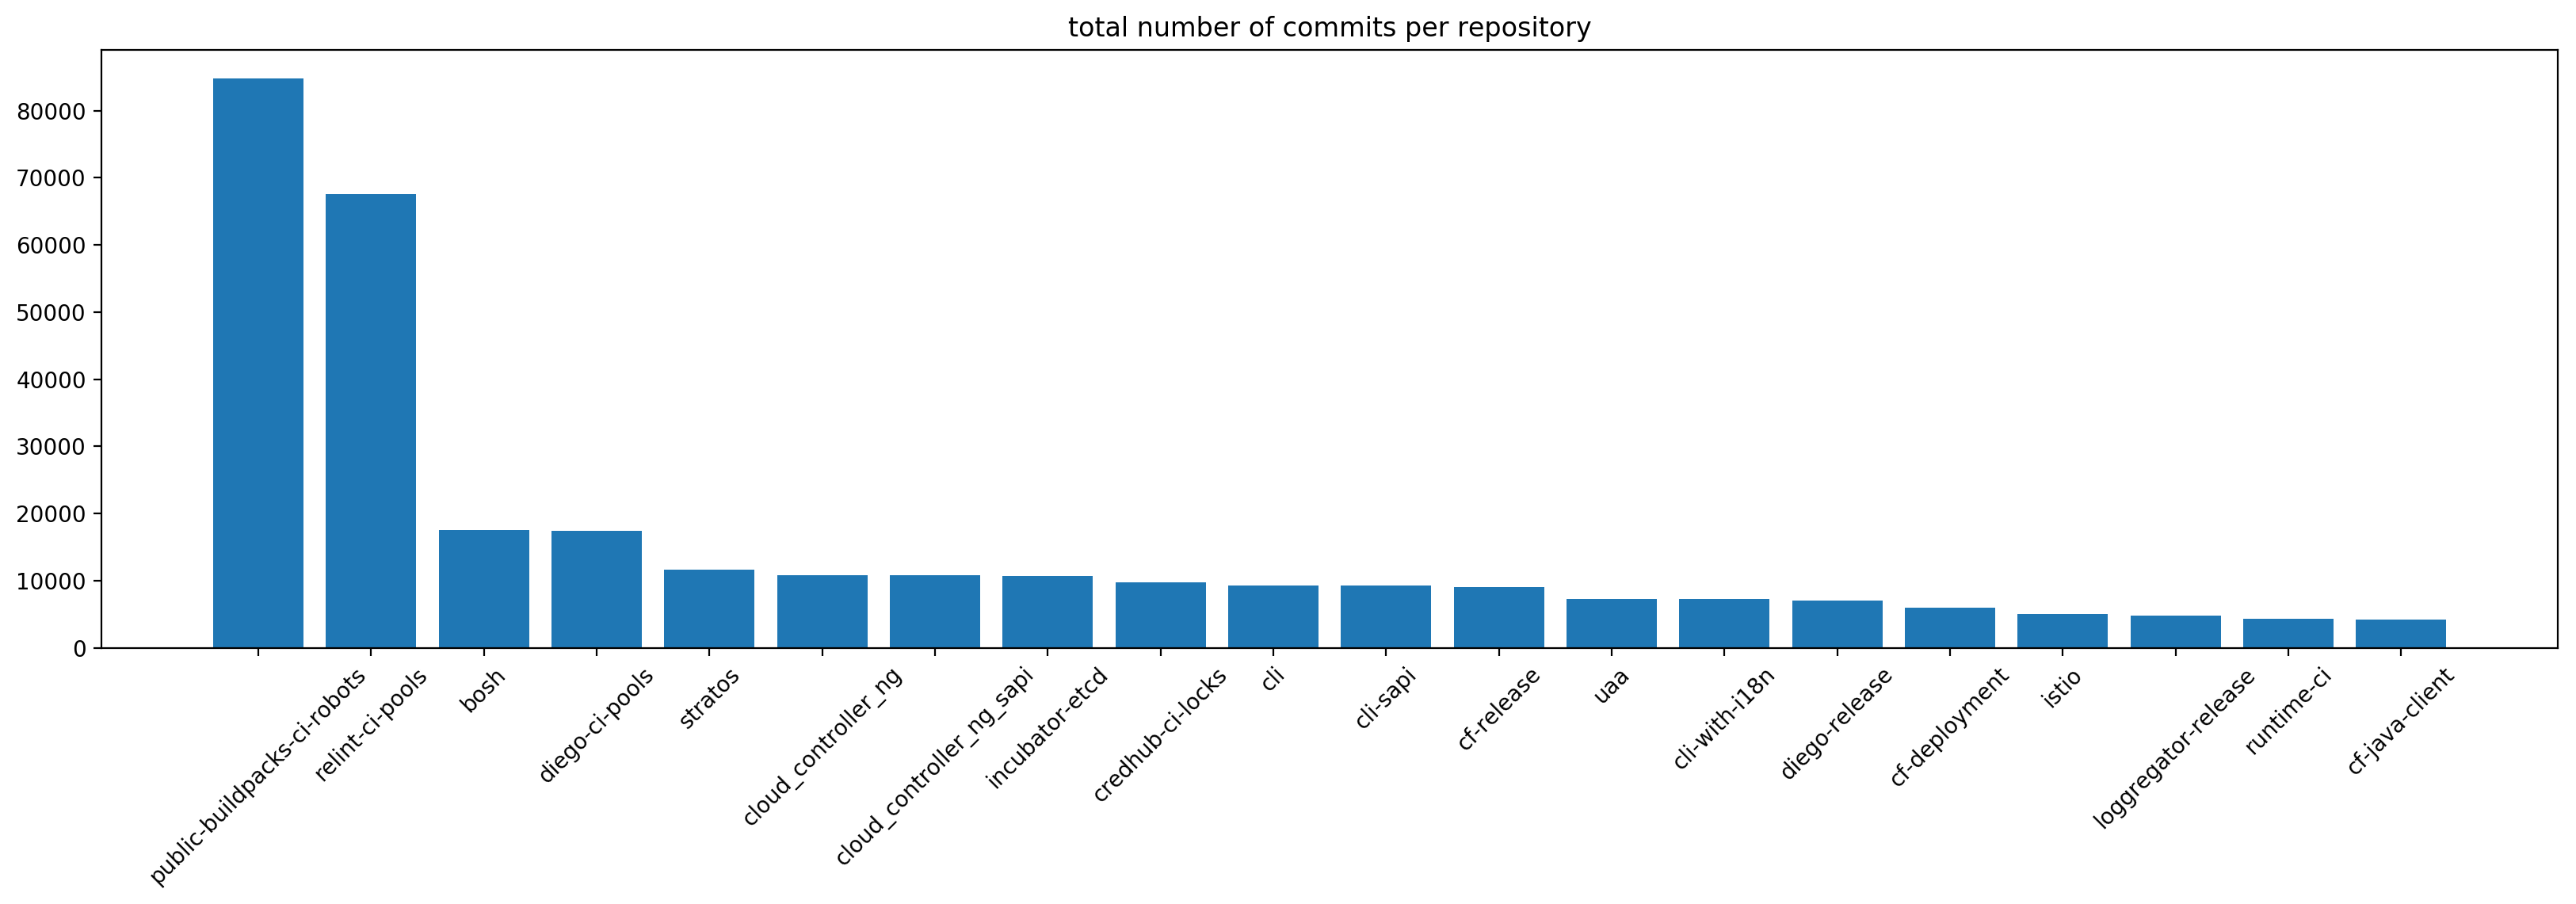

In [41]:
(repos, commits) = zip(*run('''
    SELECT repository_id, COUNT(*) as n
    FROM ref_commits
    WHERE ref_name = 'HEAD'
    GROUP BY repository_id
    ORDER BY n DESC
    LIMIT 20
'''))

plt.figure(figsize=(20,5), dpi=200)
plt.title('total number of commits per repository')
plt.bar(repos, commits)
plt.xticks(rotation=45)
plt.show()

In [100]:
# let's see how we got there, let's count the number of commits over time
# this corresponds to the reverse of the history_index field in ref_commits.

(repos, whens) = zip(*run('''
    SELECT repository_id, commit_author_when
    FROM ref_commits
    NATURAL JOIN commits
    WHERE ref_name = 'HEAD'
    ORDER BY repository_id, commit_author_when
'''))

whens_per_repo = {}
for (repo, when) in zip(repos, whens):
    l = whens_per_repo.get(repo, [])
    l.append(when)
    whens_per_repo[repo] = l

2019-03-28 00:38:51 engine-playground root[16590] INFO done in 16.73 seconds


2019-03-28 00:45:47 engine-playground matplotlib.axes._base[16590] DEBUG update_title_pos
2019-03-28 00:45:47 engine-playground matplotlib.axes._base[16590] DEBUG update_title_pos
2019-03-28 00:45:48 engine-playground matplotlib.axes._base[16590] DEBUG update_title_pos
2019-03-28 00:45:48 engine-playground matplotlib.axes._base[16590] DEBUG update_title_pos
2019-03-28 00:45:48 engine-playground matplotlib.axes._base[16590] DEBUG update_title_pos


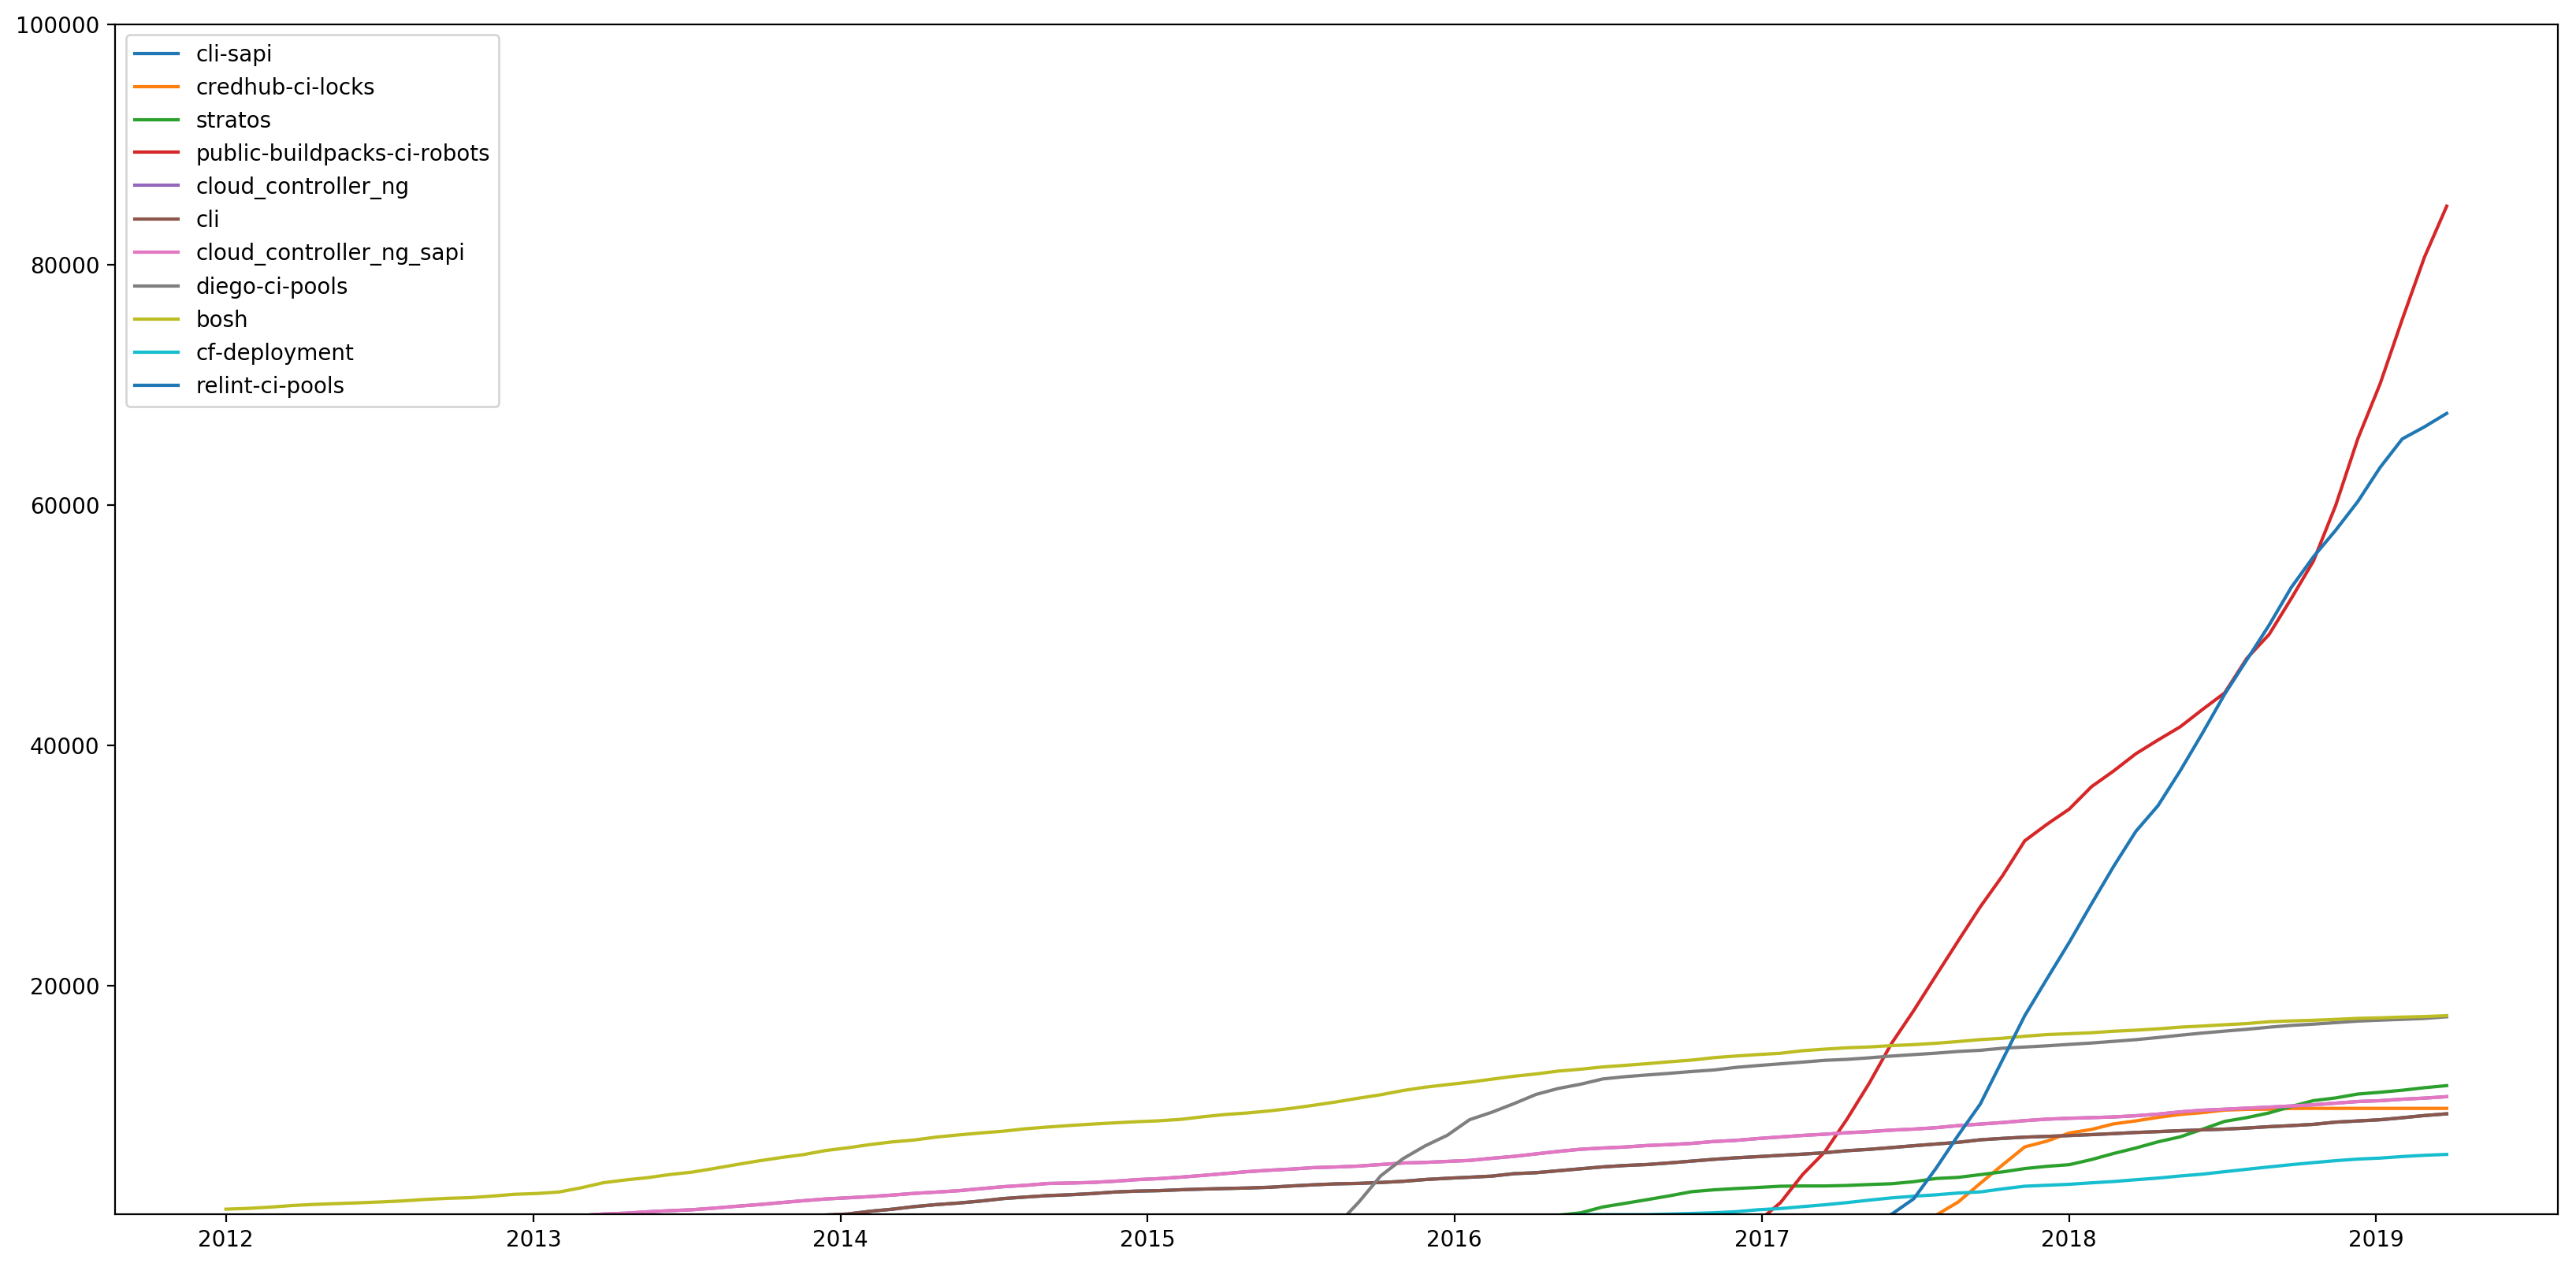

In [117]:
start = min([l[0] for l in whens_per_repo.values()])
# using second date because the first one is 6 years too soon.
start = datetime(2012,1,1)
end = max([l[-1] for l in whens_per_repo.values()])

# compute the list of dates
delta = (end-start)/100
dates = []
t = start
while t <= end:
    dates.append(t)
    t = t + delta

# find how many commits have been done at each date
commits = {}
for repo in top_repos[:-1]:
    for date in dates:
        l = commits.get(repo, [])
        l.append(bisect(whens_per_repo[repo], date))
        commits[repo] = l

plt.figure(figsize=(20,10), dpi=200)        
# plt.yscale('log')
plt.ylim(1e3,1e5)
for repo in top_repos[:-1]:
    plt.plot(dates, commits[repo])
plt.legend(top_repos[:-1])

In [85]:
from bisect import bisect

dates = []
t = start
while t <= end:
    dates.append(t)
    t = t + delta

treshold = dates[0]
repo = 'bosh'

print(bisect(whens_per_repo[repo], treshold))

0


## Number of files/lines of code over time

In [127]:
buckets = 100

def count_files_in_commit(repo, hash):
  (trees,) = zip(*run('''
    SELECT tree_hash
    FROM commit_trees
    WHERE commit_hash='%s'
  ''' % hash, log=False))

  (counts,) = zip(*run('''
    SELECT COUNT(file_path)
    FROM files
    WHERE repository_id = '%s'
      AND tree_entry_mode != 40000
      AND tree_hash in (%s)
  ''' % (repo , ', '.join(['"%s"' % x for x in trees])), log=False))
  return counts[0]

(repos, commits, whens) = zip(*run('''
    SELECT repository_id, commit_hash, commit_author_when
    FROM ref_commits 
    NATURAL JOIN commits
    WHERE ref_name = 'HEAD'
    ORDER BY repository_id, history_index DESC
'''))

# compute the list of dates
start = min(whens)
end = max(whens)
delta = (end-start)/buckets
dates = []
t = start
while t <= end:
    dates.append(t)
    t = t + delta

# create a list of commits per repository
commits_per_repo = {}
for (repo, commit, when) in zip(repos, commits, whens):
    l = commits_per_repo.get(repo, [])
    l.append((commit, when))
    commits_per_repo[repo] = l

2019-03-31 16:12:40 engine-playground root[3080] INFO done in 23.31 seconds


In [133]:
from joblib import Parallel, delayed
import multiprocessing

def get_counts(repo):
    counts = []
    for d in dates:
        commits, whens = zip(*commits_per_repo[repo])
        idx = bisect(whens, d) - 1
        count = 0 if idx < 0 else count_files_in_commit(repo, commits[idx])
        counts.append(count)
    return counts
        
file_counts = Parallel(n_jobs=-1, verbose=10)(
    delayed(get_counts)(repo) for repo in list(commits_per_repo))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 36.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-1)]: Done 229 tasks      | elapsed: 57.6min
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed: 64.6min
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed: 72.5min
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed: 80.3min
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed: 88.5min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed: 9

In [140]:
labels = ['%d-%d' % (d.year, d.month) for d in dates]
files_per_repo = {repo: np.array(file_counts[i]) for (i, repo) in enumerate(list(commits_per_repo))}


top_n = 5
treshold = sorted(np.array(list(files_per_repo.values())).sum(axis=1))[-top_n]
top_repos = list({repo for repo in files_per_repo if sum(files_per_repo[repo]) >= treshold})

others = np.sum([files_per_repo[repo] for repo in files_per_repo if repo not in top_repos], axis=0)
top_counts = [(files_per_repo[repo]) for repo in top_repos]

top_repos.append('others')
top_counts.append(np.array(others))

2019-03-31 23:51:41 engine-playground matplotlib.axes._base[3080] DEBUG update_title_pos
2019-03-31 23:51:42 engine-playground matplotlib.axes._base[3080] DEBUG update_title_pos
2019-03-31 23:51:42 engine-playground matplotlib.axes._base[3080] DEBUG update_title_pos
2019-03-31 23:51:42 engine-playground matplotlib.axes._base[3080] DEBUG update_title_pos


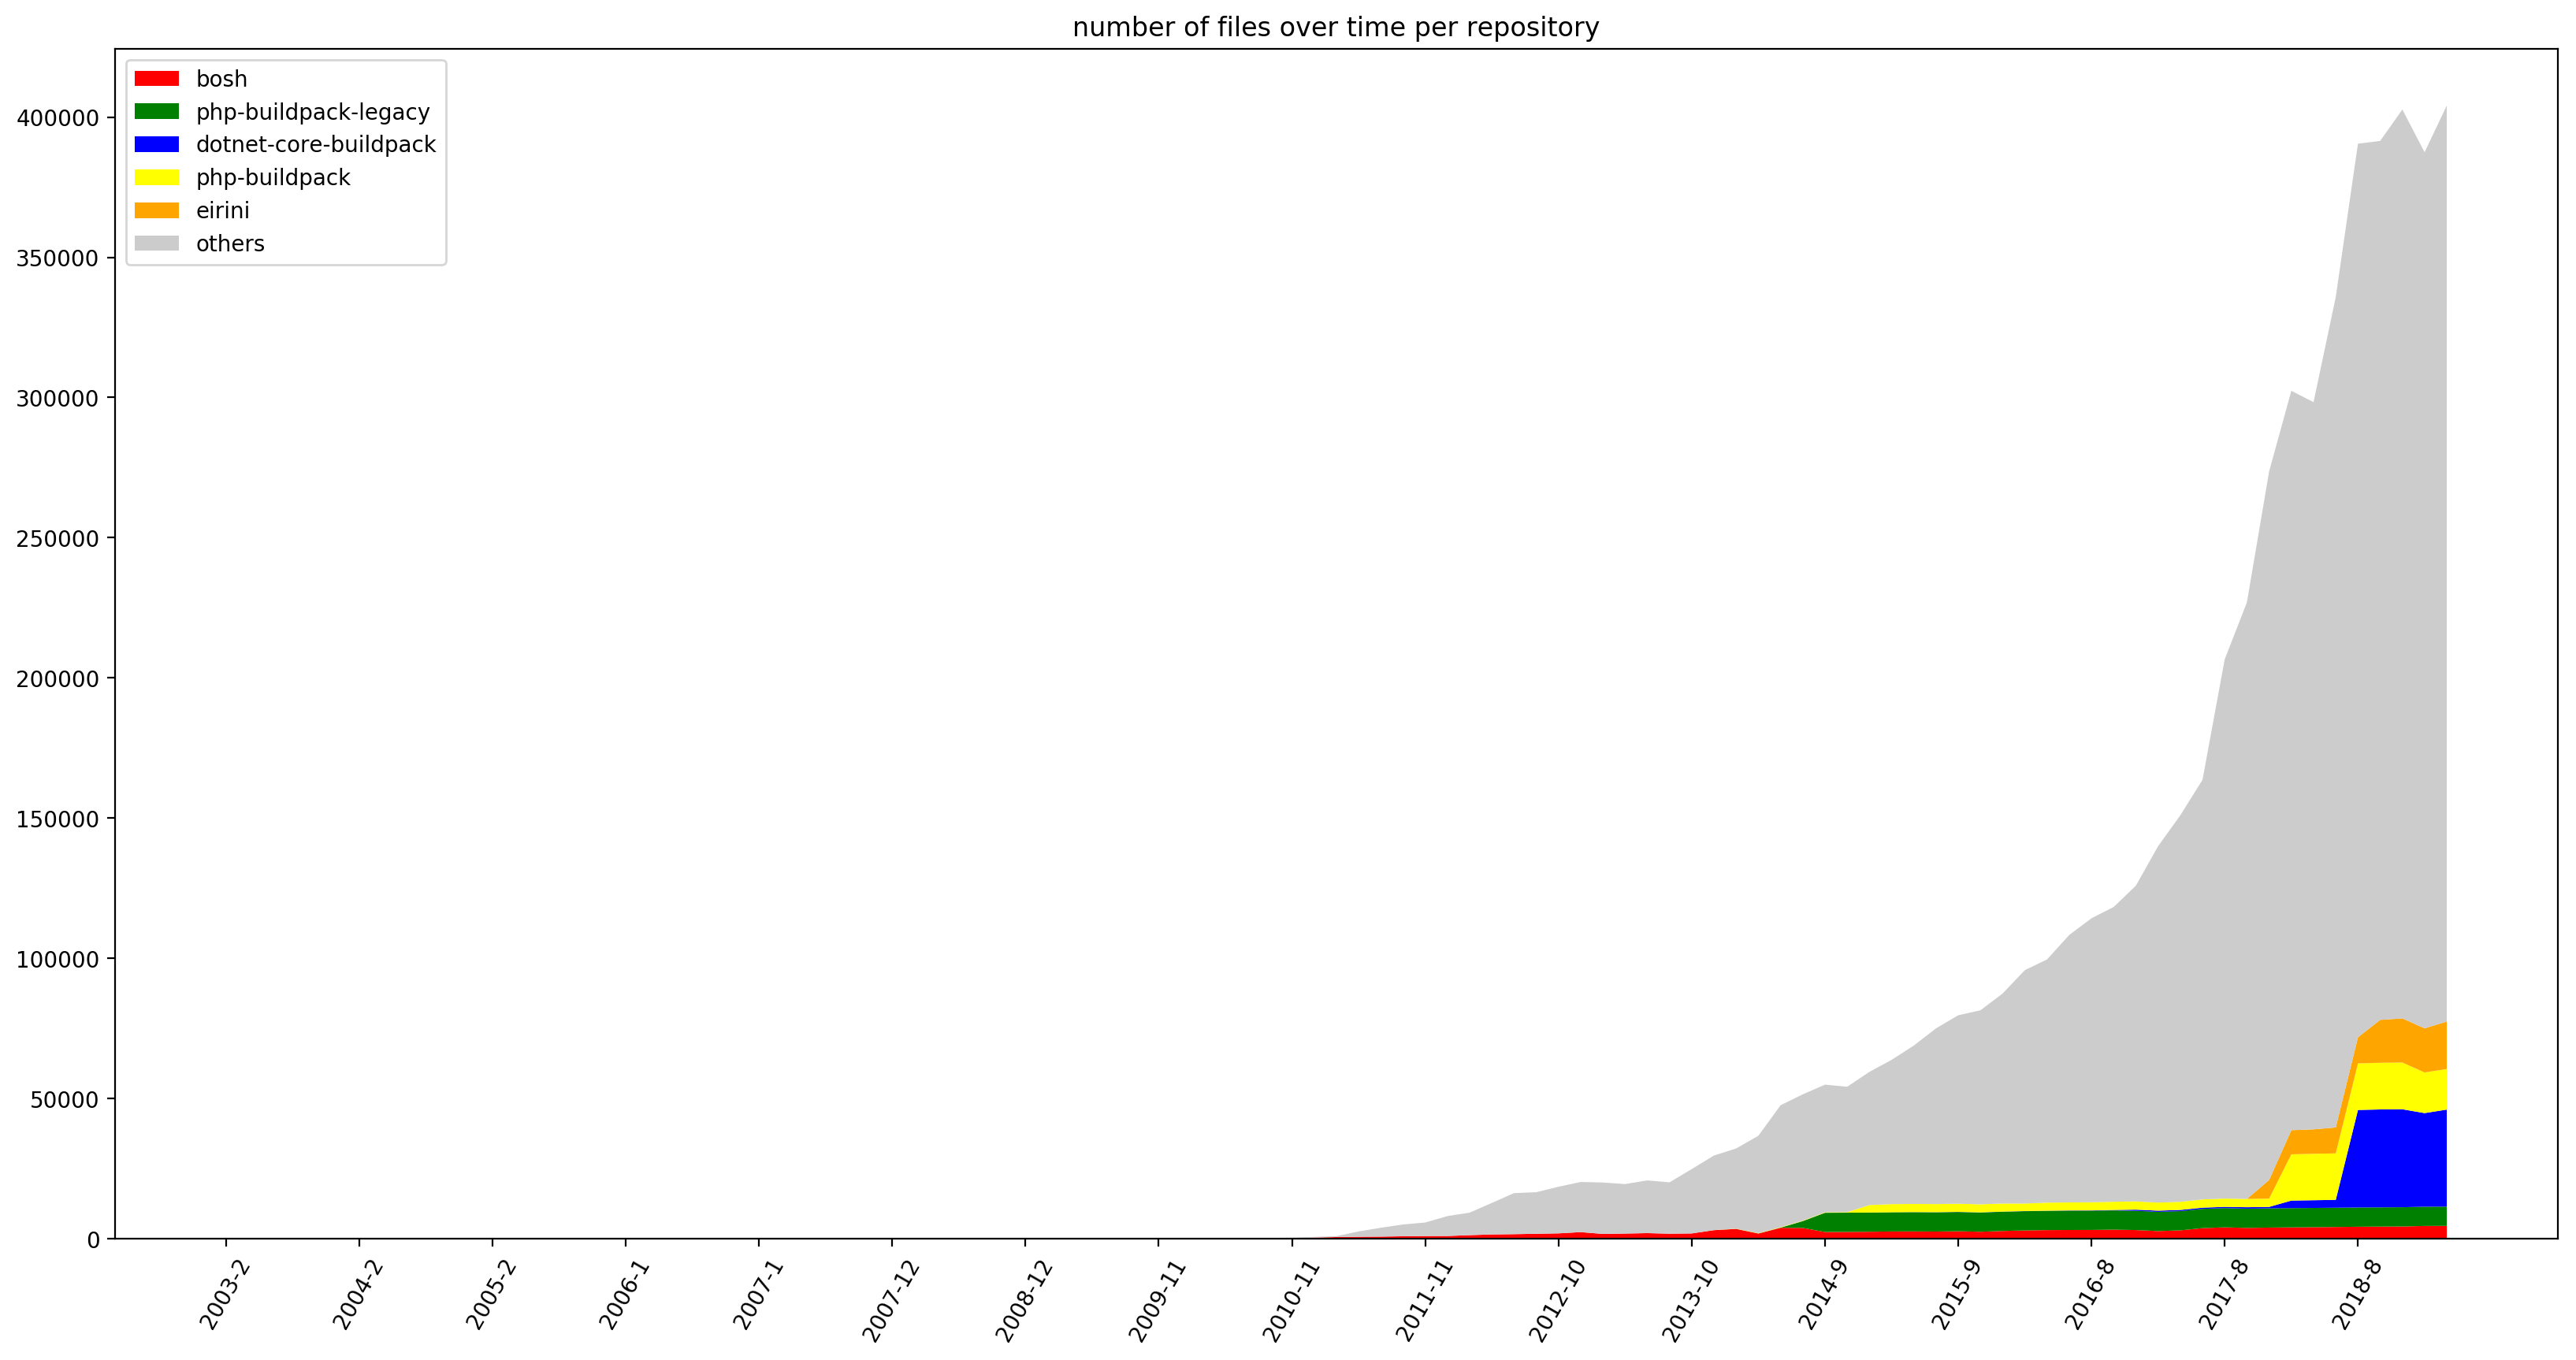

In [144]:
plt.figure(figsize=(20,10), dpi=200)
plt.title('number of files over time per repository')
plt.stackplot(labels, np.vstack(top_counts), labels=labels, colors=['red', 'green', 'blue', 'yellow', 'orange', (0.8, 0.8, 0.8)])
plt.xticks(labels[::6], rotation=60)
# plt.yscale('log')
plt.legend(top_repos, loc='upper left')
plt.show()

# Languages used

In [ ]:
langs, counts = zip(*run('''
    SELECT LANGUAGE(file_path, blob_content) AS lang, COUNT(file_path) AS n
    FROM files
    WHERE repository_id = 'bosh'
    GROUP BY lang
    ORDER BY n DESC
'''))

In [38]:
top_langs = [l for l in langs if l != ''][:7]
top_counts = [counts[langs.index(l)] for l in top_langs]
top_langs.append('others')
top_counts.append(sum(counts)-sum(top_counts))

2019-04-01 22:52:08 engine-playground matplotlib.axes._base[4080] DEBUG update_title_pos
2019-04-01 22:52:09 engine-playground matplotlib.axes._base[4080] DEBUG update_title_pos
2019-04-01 22:52:09 engine-playground matplotlib.axes._base[4080] DEBUG update_title_pos
2019-04-01 22:52:09 engine-playground matplotlib.axes._base[4080] DEBUG update_title_pos


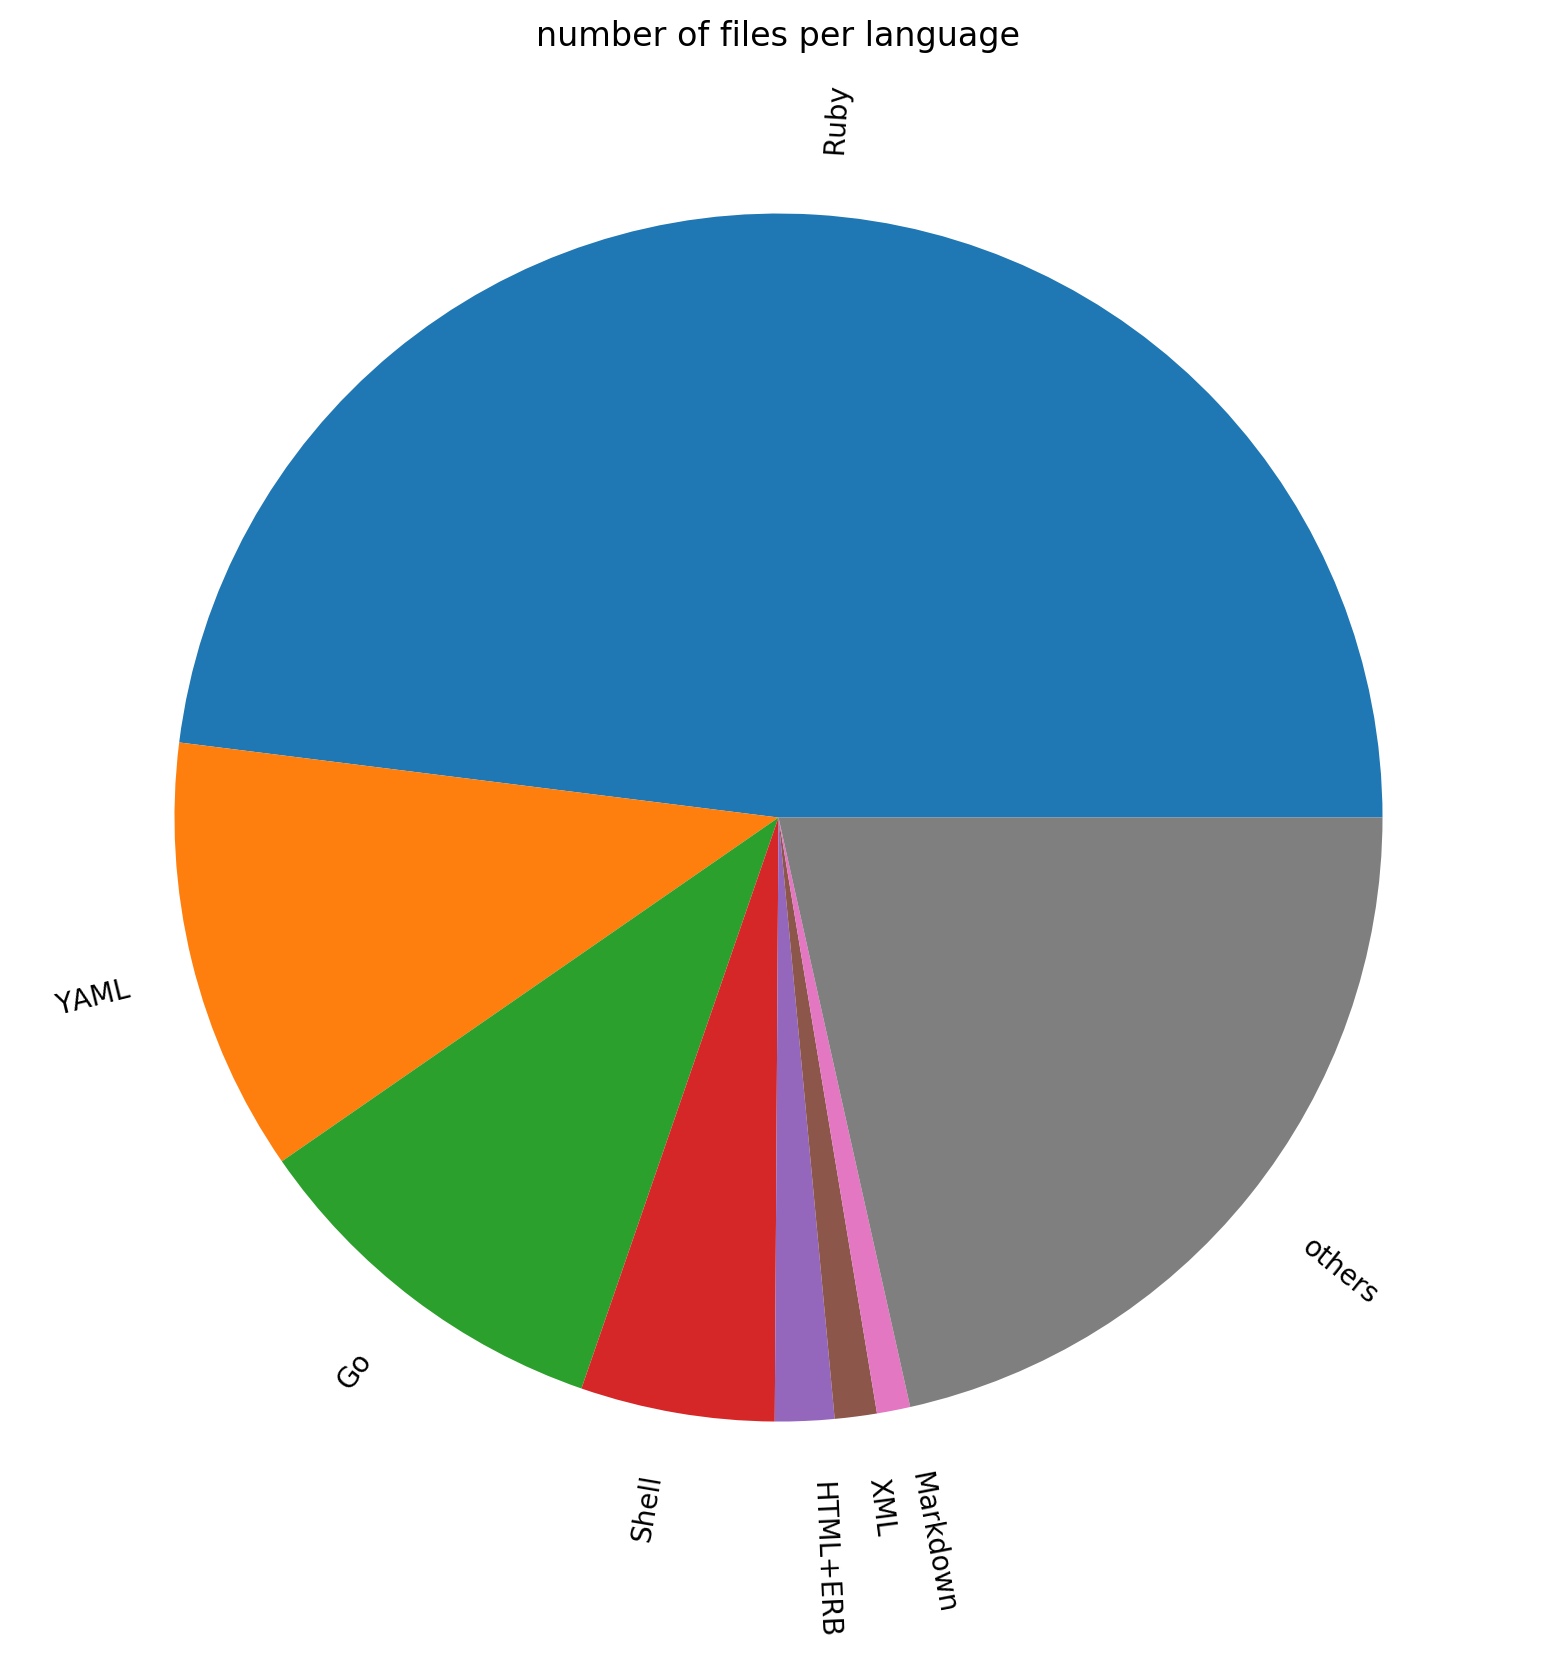

In [39]:
plt.figure(figsize=(20,10), dpi=200)
plt.title('number of files per language')
plt.pie(top_counts, labels=top_langs, rotatelabels=True)
plt.show()